In [1]:
%load_ext watermark


In [2]:
import itertools as it
import os

from IPython.display import display
import matplotlib as mpl
from matplotlib import container as mpl_container
import polars as pl
import seaborn as sns
from slugify import slugify
from teeplot import teeplot as tp


In [3]:
%watermark -diwmuv -iv


Last updated: 2025-07-21T20:36:52.412983+00:00

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 7.31.1

Compiler    : GCC 11.4.0
OS          : Linux
Release     : 6.8.0-1030-azure
Machine     : x86_64
Processor   : x86_64
CPU cores   : 4
Architecture: 64bit

matplotlib: 3.10.0
seaborn   : 0.13.2
teeplot   : 1.4.2
polars    : 1.9.0

Watermark: 2.4.3



In [4]:
tp.save[".pgf"] = True
teeplot_subdir = os.environ.get(
    "NOTEBOOK_NAME", "2025-06-01-cpp-bench-memory-native-tilted"
)
teeplot_subdir


'2025-06-30-cpp-bench-memory-tilted'

## Prep Data


In [5]:
algo_names = {
    "dstream.circular_algo": "simple ringbuf",
    "control_throwaway_algo": "no-operation",
    "dstream.tilted_algo": "extended ringbuf",
    "dstream_tilted_algo": "extended ringbuf LUT",
    "doubling_tilted_algo": "naive doubling",
    "zhao_tilted_algo": "pyramidal bucket",
    "zhao_tilted_full_algo": "saturating bucket",
}


df = pl.concat(
    [
        pl.read_csv("https://osf.io/cbqpx/download"),
    ],
)
print("\n".join(df["algo_name"].unique().to_list()))
df = (
    df.cast(
        {
            "memory_bytes": pl.Int32,
            "num_items": pl.Int32,
            "num_sites": pl.Int32,
            "duration_s": pl.Float64,
            "replicate": pl.Int32,
        },
    )
    .filter(
        pl.col("algo_name").is_in(
            algo_names.keys(),
        ),
        pl.col("num_items") == 1_000_000,
    )
    .with_columns(
        algorithm=pl.col("algo_name").map_elements(
            algo_names.__getitem__,
            return_dtype=str,
        ),
        num_retained=(
            pl.when(pl.col("algo_name") == "dstream_tilted_algo")
            .then(pl.col("num_sites"))
            .when(pl.col("algo_name") == "doubling_tilted_algo")
            .then(pl.col("num_sites") * 0.75)
            .when(pl.col("algo_name") == "zhao_tilted_algo")
            .then(19)
            .when(pl.col("algo_name") == "zhao_tilted_full_algo")
            .then(pl.col("num_sites"))
            .otherwise(pl.col("num_sites"))
        )
    )
    .with_columns(
        (pl.col("memory_bytes") / pl.col("num_retained")).alias("bytes per item"),
    )
    .with_columns(
        (8 * pl.col("memory_bytes") / pl.col("num_retained")).alias("bits per item"),
    )
    .with_columns(
        memory_bits=pl.col("memory_bytes") * 8,
        item_bits=(
            pl.col("data_type")
            .map_elements(
                {
                    "bit": 1, "byte": 8, "word": 16, "double word": 32
                }.get,
                return_dtype=pl.Int32,
            )
        ),
    )
    .with_columns(
        overhead_bits=(
            pl.col("memory_bits") - pl.col("item_bits") * pl.col("num_retained")
        ),
    )
    .with_columns(overhead_bytes=pl.col("overhead_bits") // 8)
    .with_columns(
        (
            100 * pl.col("item_bits") / pl.col("bits per item")
        ).alias("Memory Efficiency (%)"),
    )
    .with_columns(pl.col("data_type").alias("data type"))
)

display(df.describe()), display(df.head()), display(df.tail());


zhao_tilted_full_algo
dstream_tilted_algo
zhao_tilted_algo
dstream_stretched_algo
doubling_tilted_algo
dstream.steady_algo
doubling_steady_algo
dstream.compressing_algo
dstream.stretched_algo
zhao_steady_algo
dstream.circular_algo
control_throwaway_algo
dstream.tilted_algo


statistic,algo_name,data_type,compiler,memory_bytes,num_items,num_sites,replicate,duration_s,algorithm,num_retained,bytes per item,bits per item,memory_bits,item_bits,overhead_bits,overhead_bytes,Memory Efficiency (%),data type
str,str,str,str,f64,f64,f64,f64,f64,str,f64,f64,f64,f64,f64,f64,f64,f64,str
"""count""","""1120""","""1120""","""1120""",1120.0,1120.0,1120.0,1120.0,1120.0,"""1120""",1120.0,1120.0,1120.0,1120.0,1120.0,1120.0,1120.0,1120.0,"""1120"""
"""null_count""","""0""","""0""","""0""",0.0,0.0,0.0,0.0,0.0,"""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"""0"""
"""mean""",null,null,null,2106.571429,1e6,1360.0,4.5,5.660586,null,1119.857143,2.280555,18.244439,16852.571429,14.25,894.607143,111.803571,80.853022,null
"""std""",null,null,null,3978.521282,0.0,1620.679234,2.873564,23.588329,null,1517.611823,1.710403,13.683223,31828.170259,11.545844,3581.646965,447.70889,25.453662,null
"""min""","""control_throwaway_algo""","""bit""","""g++""",12.0,1e6,64.0,0.0,0.080037,"""extended ringbuf""",19.0,0.125977,1.0078125,96.0,1.0,32.0,4.0,4.398148,"""bit"""
"""25%""",null,null,null,119.0,1e6,256.0,2.0,0.196042,null,64.0,1.003906,8.03125,952.0,8.0,32.0,4.0,70.588235,null
"""50%""",null,null,null,320.0,1e6,1024.0,5.0,1.133214,null,256.0,2.015625,16.125,2560.0,16.0,32.0,4.0,96.969697,null
"""75%""",null,null,null,2052.0,1e6,1024.0,7.0,2.020015,null,1024.0,4.000977,32.007812,16416.0,16.0,413.0,51.0,99.224806,null
"""max""","""zhao_tilted_full_algo""","""word""","""g++""",16512.0,1e6,4096.0,9.0,204.034583,"""simple ringbuf""",4096.0,6.263158,50.105263,132096.0,32.0,32800.0,4100.0,99.975592,"""word"""


algo_name,data_type,compiler,memory_bytes,num_items,num_sites,replicate,duration_s,algorithm,num_retained,bytes per item,bits per item,memory_bits,item_bits,overhead_bits,overhead_bytes,Memory Efficiency (%),data type
str,str,str,i32,i32,i32,i32,f64,str,f64,f64,f64,i32,i32,f64,f64,f64,str
"""control_throwaway_algo""","""double word""","""g++""",16388,1000000,4096,0,0.080503,"""no-operation""",4096.0,4.000977,32.007812,131104,32,32.0,4.0,99.975592,"""double word"""
"""control_throwaway_algo""","""double word""","""g++""",16388,1000000,4096,1,0.080506,"""no-operation""",4096.0,4.000977,32.007812,131104,32,32.0,4.0,99.975592,"""double word"""
"""control_throwaway_algo""","""double word""","""g++""",16388,1000000,4096,2,0.080556,"""no-operation""",4096.0,4.000977,32.007812,131104,32,32.0,4.0,99.975592,"""double word"""
"""control_throwaway_algo""","""double word""","""g++""",16388,1000000,4096,3,0.080556,"""no-operation""",4096.0,4.000977,32.007812,131104,32,32.0,4.0,99.975592,"""double word"""
"""control_throwaway_algo""","""double word""","""g++""",16388,1000000,4096,4,0.080506,"""no-operation""",4096.0,4.000977,32.007812,131104,32,32.0,4.0,99.975592,"""double word"""


algo_name,data_type,compiler,memory_bytes,num_items,num_sites,replicate,duration_s,algorithm,num_retained,bytes per item,bits per item,memory_bits,item_bits,overhead_bits,overhead_bytes,Memory Efficiency (%),data type
str,str,str,i32,i32,i32,i32,f64,str,f64,f64,f64,i32,i32,f64,f64,f64,str
"""zhao_tilted_full_algo""","""bit""","""g++""",72,1000000,64,5,3.017475,"""saturating bucket""",64.0,1.125,9.0,576,1,512.0,64.0,11.111111,"""bit"""
"""zhao_tilted_full_algo""","""bit""","""g++""",72,1000000,64,6,3.017482,"""saturating bucket""",64.0,1.125,9.0,576,1,512.0,64.0,11.111111,"""bit"""
"""zhao_tilted_full_algo""","""bit""","""g++""",72,1000000,64,7,3.017487,"""saturating bucket""",64.0,1.125,9.0,576,1,512.0,64.0,11.111111,"""bit"""
"""zhao_tilted_full_algo""","""bit""","""g++""",72,1000000,64,8,3.017428,"""saturating bucket""",64.0,1.125,9.0,576,1,512.0,64.0,11.111111,"""bit"""
"""zhao_tilted_full_algo""","""bit""","""g++""",72,1000000,64,9,3.017484,"""saturating bucket""",64.0,1.125,9.0,576,1,512.0,64.0,11.111111,"""bit"""


In [6]:
assert (df.group_by(
    ["num_items", "num_sites", "algorithm", "data type"],
).agg(
    pl.col("memory_bytes").n_unique(),
)["memory_bytes"] == 1).all()


In [7]:
hue_order = [
    "extended ringbuf",
    "saturating bucket",
    "pyramidal bucket",
    # "extended ringbuf LUT",
    # "simple ringbuf",
    "naive doubling",
]


In [8]:
palette = [
    "#9C4897",
    "#6D61A7",
    "#63a28b",
    "#828282",
    "#fac746",
    "#89ccf2",
    "#baf23d",
]

palette_assignments = {
    "extended ringbuf": palette[0],
    "extended ringbuf LUT": palette[1],
    "saturating bucket": palette[2],
    "pyramidal bucket": palette[6],
    "simple ringbuf": palette[5],
    "naive doubling": palette[3],
    "no-operation": palette[4],
}


## Plot


## Memory Per Item --- Stacked


teeplots/2025-06-30-cpp-bench-memory-tilted/col=stat+excl=+hue=algorithm+kind=bar+legend=True+row=data-type+viz=catplot+x=num-sites+y=bits-per-item+ext=.pdf
teeplots/2025-06-30-cpp-bench-memory-tilted/col=stat+excl=+hue=algorithm+kind=bar+legend=True+row=data-type+viz=catplot+x=num-sites+y=bits-per-item+ext=.pgf
teeplots/2025-06-30-cpp-bench-memory-tilted/col=stat+excl=+hue=algorithm+kind=bar+legend=True+row=data-type+viz=catplot+x=num-sites+y=bits-per-item+ext=.png


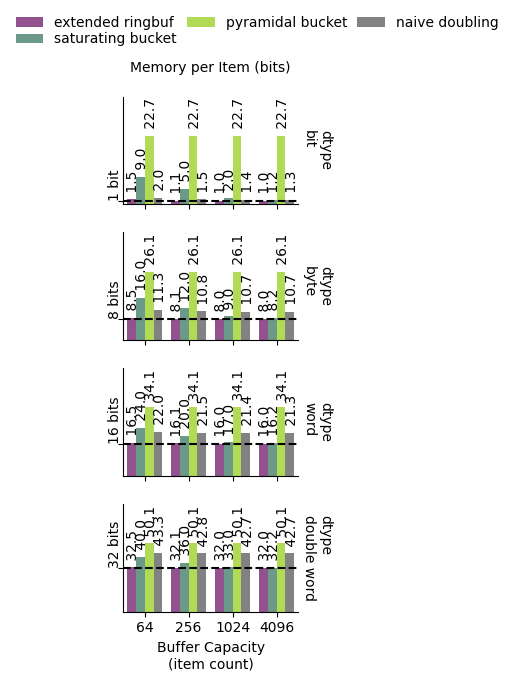

teeplots/2025-06-30-cpp-bench-memory-tilted/col=stat+excl=+font.family=serif+hue=algorithm+kind=bar+legend=True+row=data-type+viz=catplot+x=num-sites+y=bits-per-item+ext=.pdf
teeplots/2025-06-30-cpp-bench-memory-tilted/col=stat+excl=+font.family=serif+hue=algorithm+kind=bar+legend=True+row=data-type+viz=catplot+x=num-sites+y=bits-per-item+ext=.pgf
teeplots/2025-06-30-cpp-bench-memory-tilted/col=stat+excl=+font.family=serif+hue=algorithm+kind=bar+legend=True+row=data-type+viz=catplot+x=num-sites+y=bits-per-item+ext=.png


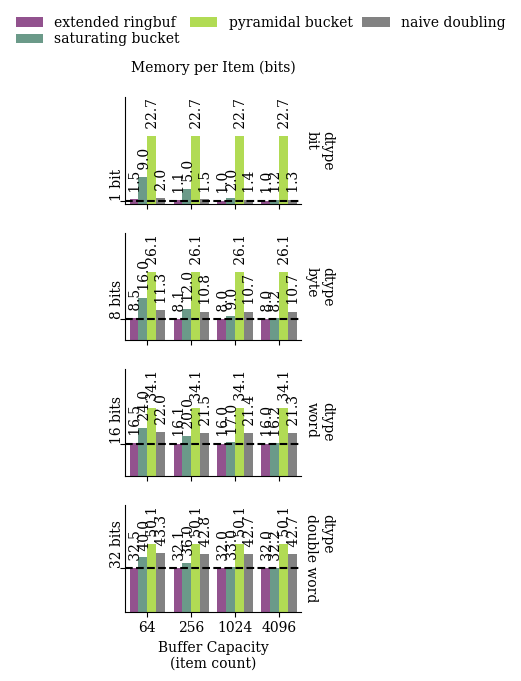

teeplots/2025-06-30-cpp-bench-memory-tilted/col=stat+excl=pyramidal-bucket+hue=algorithm+kind=bar+legend=True+row=data-type+viz=catplot+x=num-sites+y=bits-per-item+ext=.pdf
teeplots/2025-06-30-cpp-bench-memory-tilted/col=stat+excl=pyramidal-bucket+hue=algorithm+kind=bar+legend=True+row=data-type+viz=catplot+x=num-sites+y=bits-per-item+ext=.pgf
teeplots/2025-06-30-cpp-bench-memory-tilted/col=stat+excl=pyramidal-bucket+hue=algorithm+kind=bar+legend=True+row=data-type+viz=catplot+x=num-sites+y=bits-per-item+ext=.png


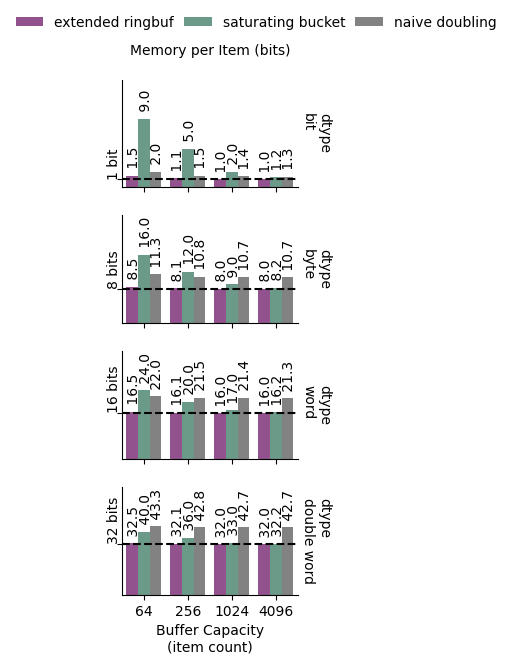

teeplots/2025-06-30-cpp-bench-memory-tilted/col=stat+excl=pyramidal-bucket+font.family=serif+hue=algorithm+kind=bar+legend=True+row=data-type+viz=catplot+x=num-sites+y=bits-per-item+ext=.pdf
teeplots/2025-06-30-cpp-bench-memory-tilted/col=stat+excl=pyramidal-bucket+font.family=serif+hue=algorithm+kind=bar+legend=True+row=data-type+viz=catplot+x=num-sites+y=bits-per-item+ext=.pgf
teeplots/2025-06-30-cpp-bench-memory-tilted/col=stat+excl=pyramidal-bucket+font.family=serif+hue=algorithm+kind=bar+legend=True+row=data-type+viz=catplot+x=num-sites+y=bits-per-item+ext=.png


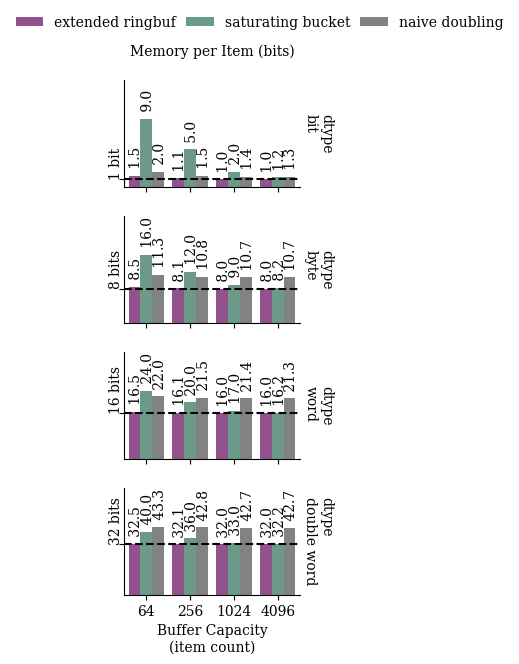

teeplots/2025-06-30-cpp-bench-memory-tilted/col=stat+excl=+hue=algorithm+kind=bar+legend=False+row=data-type+viz=catplot+x=num-sites+y=bits-per-item+ext=.pdf
teeplots/2025-06-30-cpp-bench-memory-tilted/col=stat+excl=+hue=algorithm+kind=bar+legend=False+row=data-type+viz=catplot+x=num-sites+y=bits-per-item+ext=.pgf
teeplots/2025-06-30-cpp-bench-memory-tilted/col=stat+excl=+hue=algorithm+kind=bar+legend=False+row=data-type+viz=catplot+x=num-sites+y=bits-per-item+ext=.png


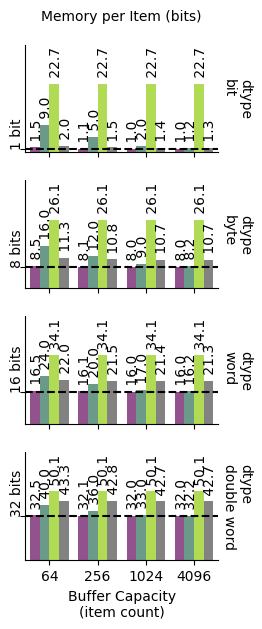

teeplots/2025-06-30-cpp-bench-memory-tilted/col=stat+excl=+font.family=serif+hue=algorithm+kind=bar+legend=False+row=data-type+viz=catplot+x=num-sites+y=bits-per-item+ext=.pdf
teeplots/2025-06-30-cpp-bench-memory-tilted/col=stat+excl=+font.family=serif+hue=algorithm+kind=bar+legend=False+row=data-type+viz=catplot+x=num-sites+y=bits-per-item+ext=.pgf
teeplots/2025-06-30-cpp-bench-memory-tilted/col=stat+excl=+font.family=serif+hue=algorithm+kind=bar+legend=False+row=data-type+viz=catplot+x=num-sites+y=bits-per-item+ext=.png


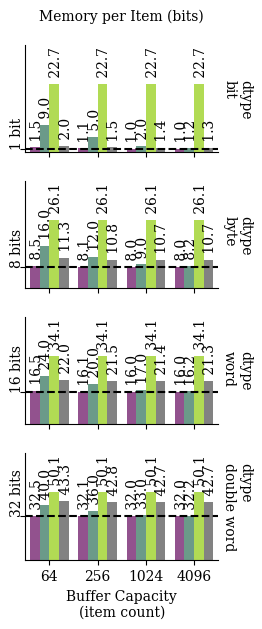

teeplots/2025-06-30-cpp-bench-memory-tilted/col=stat+excl=pyramidal-bucket+hue=algorithm+kind=bar+legend=False+row=data-type+viz=catplot+x=num-sites+y=bits-per-item+ext=.pdf
teeplots/2025-06-30-cpp-bench-memory-tilted/col=stat+excl=pyramidal-bucket+hue=algorithm+kind=bar+legend=False+row=data-type+viz=catplot+x=num-sites+y=bits-per-item+ext=.pgf
teeplots/2025-06-30-cpp-bench-memory-tilted/col=stat+excl=pyramidal-bucket+hue=algorithm+kind=bar+legend=False+row=data-type+viz=catplot+x=num-sites+y=bits-per-item+ext=.png


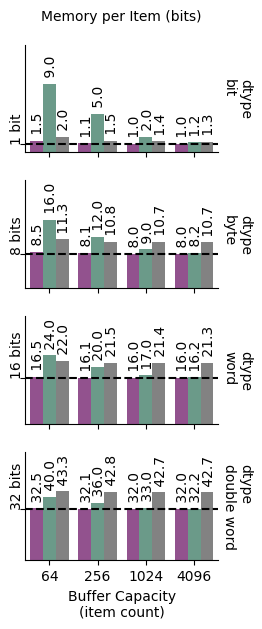

teeplots/2025-06-30-cpp-bench-memory-tilted/col=stat+excl=pyramidal-bucket+font.family=serif+hue=algorithm+kind=bar+legend=False+row=data-type+viz=catplot+x=num-sites+y=bits-per-item+ext=.pdf
teeplots/2025-06-30-cpp-bench-memory-tilted/col=stat+excl=pyramidal-bucket+font.family=serif+hue=algorithm+kind=bar+legend=False+row=data-type+viz=catplot+x=num-sites+y=bits-per-item+ext=.pgf
teeplots/2025-06-30-cpp-bench-memory-tilted/col=stat+excl=pyramidal-bucket+font.family=serif+hue=algorithm+kind=bar+legend=False+row=data-type+viz=catplot+x=num-sites+y=bits-per-item+ext=.png


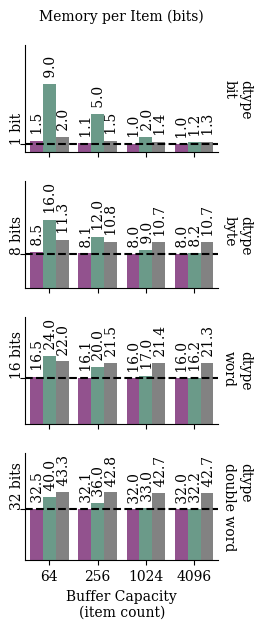

teeplots/2025-06-30-cpp-bench-memory-tilted/col=stat+excl=+hue=algorithm+kind=bar+legend=True+row=data-type+viz=catplot+x=num-sites+y=bytes-per-item+ext=.pdf
teeplots/2025-06-30-cpp-bench-memory-tilted/col=stat+excl=+hue=algorithm+kind=bar+legend=True+row=data-type+viz=catplot+x=num-sites+y=bytes-per-item+ext=.pgf
teeplots/2025-06-30-cpp-bench-memory-tilted/col=stat+excl=+hue=algorithm+kind=bar+legend=True+row=data-type+viz=catplot+x=num-sites+y=bytes-per-item+ext=.png


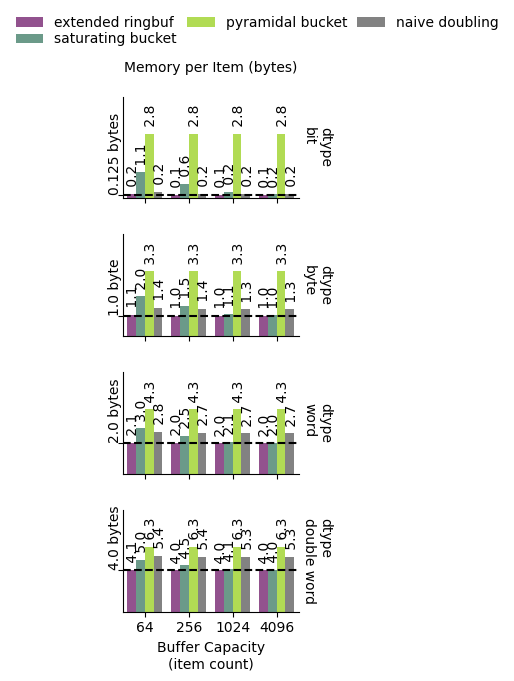

teeplots/2025-06-30-cpp-bench-memory-tilted/col=stat+excl=+font.family=serif+hue=algorithm+kind=bar+legend=True+row=data-type+viz=catplot+x=num-sites+y=bytes-per-item+ext=.pdf
teeplots/2025-06-30-cpp-bench-memory-tilted/col=stat+excl=+font.family=serif+hue=algorithm+kind=bar+legend=True+row=data-type+viz=catplot+x=num-sites+y=bytes-per-item+ext=.pgf
teeplots/2025-06-30-cpp-bench-memory-tilted/col=stat+excl=+font.family=serif+hue=algorithm+kind=bar+legend=True+row=data-type+viz=catplot+x=num-sites+y=bytes-per-item+ext=.png


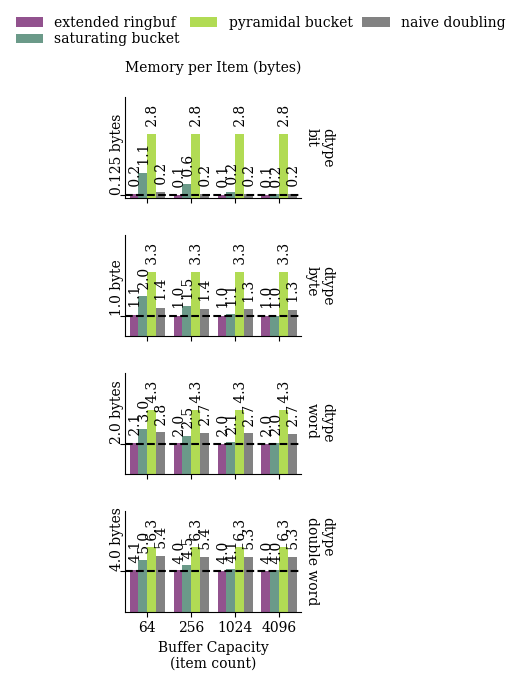

teeplots/2025-06-30-cpp-bench-memory-tilted/col=stat+excl=pyramidal-bucket+hue=algorithm+kind=bar+legend=True+row=data-type+viz=catplot+x=num-sites+y=bytes-per-item+ext=.pdf
teeplots/2025-06-30-cpp-bench-memory-tilted/col=stat+excl=pyramidal-bucket+hue=algorithm+kind=bar+legend=True+row=data-type+viz=catplot+x=num-sites+y=bytes-per-item+ext=.pgf
teeplots/2025-06-30-cpp-bench-memory-tilted/col=stat+excl=pyramidal-bucket+hue=algorithm+kind=bar+legend=True+row=data-type+viz=catplot+x=num-sites+y=bytes-per-item+ext=.png


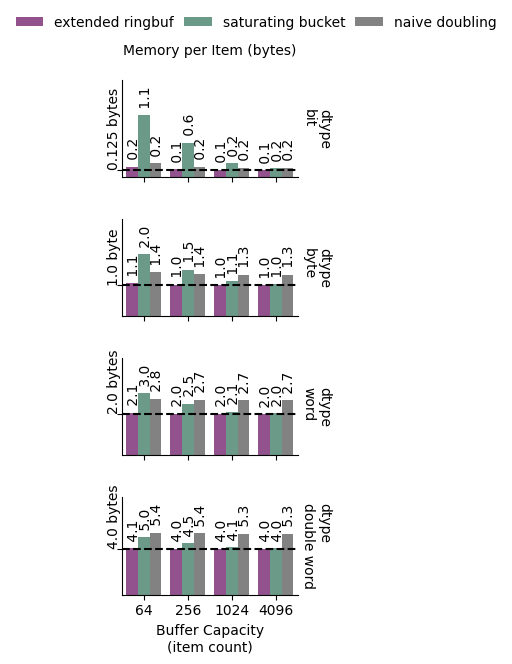

teeplots/2025-06-30-cpp-bench-memory-tilted/col=stat+excl=pyramidal-bucket+font.family=serif+hue=algorithm+kind=bar+legend=True+row=data-type+viz=catplot+x=num-sites+y=bytes-per-item+ext=.pdf
teeplots/2025-06-30-cpp-bench-memory-tilted/col=stat+excl=pyramidal-bucket+font.family=serif+hue=algorithm+kind=bar+legend=True+row=data-type+viz=catplot+x=num-sites+y=bytes-per-item+ext=.pgf
teeplots/2025-06-30-cpp-bench-memory-tilted/col=stat+excl=pyramidal-bucket+font.family=serif+hue=algorithm+kind=bar+legend=True+row=data-type+viz=catplot+x=num-sites+y=bytes-per-item+ext=.png


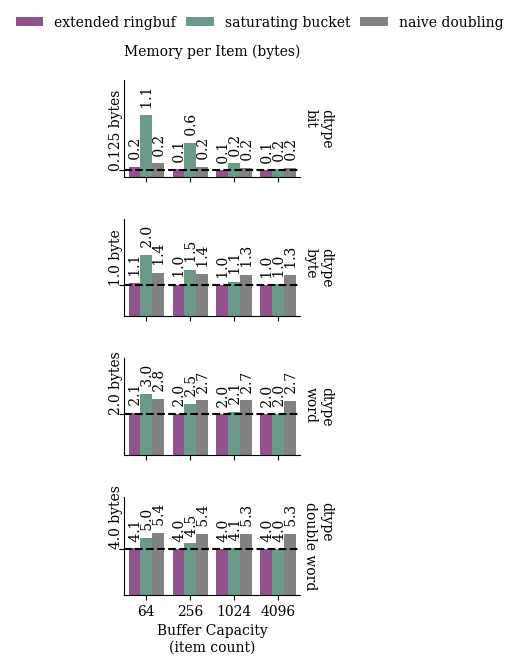

teeplots/2025-06-30-cpp-bench-memory-tilted/col=stat+excl=+hue=algorithm+kind=bar+legend=False+row=data-type+viz=catplot+x=num-sites+y=bytes-per-item+ext=.pdf
teeplots/2025-06-30-cpp-bench-memory-tilted/col=stat+excl=+hue=algorithm+kind=bar+legend=False+row=data-type+viz=catplot+x=num-sites+y=bytes-per-item+ext=.pgf
teeplots/2025-06-30-cpp-bench-memory-tilted/col=stat+excl=+hue=algorithm+kind=bar+legend=False+row=data-type+viz=catplot+x=num-sites+y=bytes-per-item+ext=.png


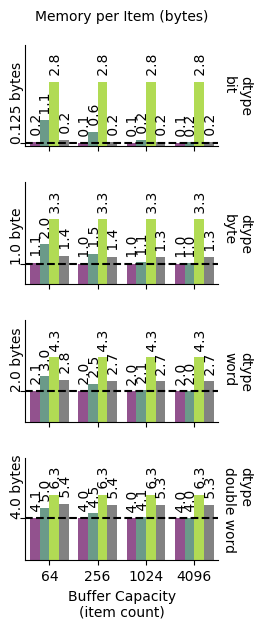

teeplots/2025-06-30-cpp-bench-memory-tilted/col=stat+excl=+font.family=serif+hue=algorithm+kind=bar+legend=False+row=data-type+viz=catplot+x=num-sites+y=bytes-per-item+ext=.pdf
teeplots/2025-06-30-cpp-bench-memory-tilted/col=stat+excl=+font.family=serif+hue=algorithm+kind=bar+legend=False+row=data-type+viz=catplot+x=num-sites+y=bytes-per-item+ext=.pgf
teeplots/2025-06-30-cpp-bench-memory-tilted/col=stat+excl=+font.family=serif+hue=algorithm+kind=bar+legend=False+row=data-type+viz=catplot+x=num-sites+y=bytes-per-item+ext=.png


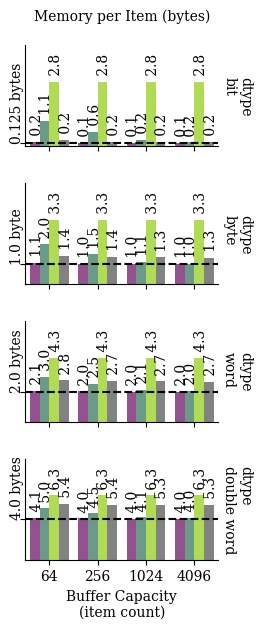

teeplots/2025-06-30-cpp-bench-memory-tilted/col=stat+excl=pyramidal-bucket+hue=algorithm+kind=bar+legend=False+row=data-type+viz=catplot+x=num-sites+y=bytes-per-item+ext=.pdf
teeplots/2025-06-30-cpp-bench-memory-tilted/col=stat+excl=pyramidal-bucket+hue=algorithm+kind=bar+legend=False+row=data-type+viz=catplot+x=num-sites+y=bytes-per-item+ext=.pgf
teeplots/2025-06-30-cpp-bench-memory-tilted/col=stat+excl=pyramidal-bucket+hue=algorithm+kind=bar+legend=False+row=data-type+viz=catplot+x=num-sites+y=bytes-per-item+ext=.png


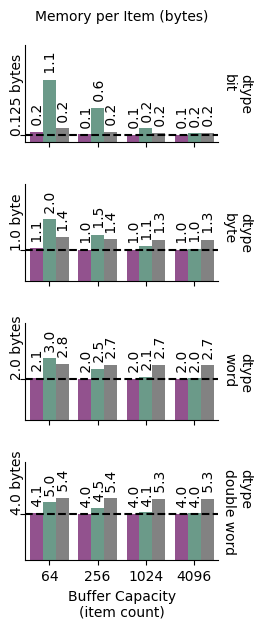

teeplots/2025-06-30-cpp-bench-memory-tilted/col=stat+excl=pyramidal-bucket+font.family=serif+hue=algorithm+kind=bar+legend=False+row=data-type+viz=catplot+x=num-sites+y=bytes-per-item+ext=.pdf
teeplots/2025-06-30-cpp-bench-memory-tilted/col=stat+excl=pyramidal-bucket+font.family=serif+hue=algorithm+kind=bar+legend=False+row=data-type+viz=catplot+x=num-sites+y=bytes-per-item+ext=.pgf
teeplots/2025-06-30-cpp-bench-memory-tilted/col=stat+excl=pyramidal-bucket+font.family=serif+hue=algorithm+kind=bar+legend=False+row=data-type+viz=catplot+x=num-sites+y=bytes-per-item+ext=.png


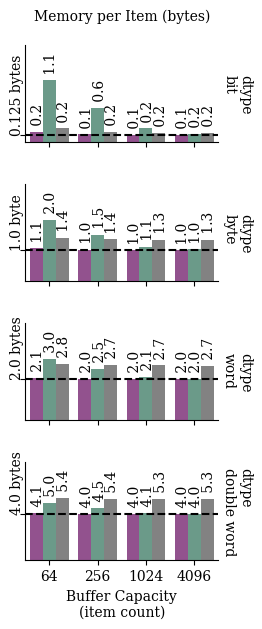

In [9]:
for unit, legend, excl, rc in it.product(
    ["bits", "bytes"],
    [True, False],
    [[], ["pyramidal bucket"]],
    [{}, {"font.family": "serif"}],
):
    excl_hue_order = [hue for hue in hue_order if hue not in excl]
    with mpl.rc_context(rc=rc):
        with tp.teed(
            sns.catplot,
            data=df.filter(
                pl.col("num_items") == 1_000_000,
            ).with_columns(
                stat=pl.lit(f"Memory per Item ({unit})\n"),
            ),
            x="num_sites",
            y=f"{unit} per item",
            hue="algorithm",
            hue_order=excl_hue_order,
            col="stat",
            row="data type",
            row_order=["bit", "byte", "word", "double word"],
            kind="bar",
            errorbar=None,
            margin_titles=True,
            legend=legend,
            aspect=1.7,
            height=1.6,
            palette=[*map(palette_assignments.get, excl_hue_order)],
            sharex=True,
            sharey=False,
            teeplot_outattrs={
                "excl": slugify("-".join(excl)),
                "legend": legend,
                **rc,
            },
            teeplot_subdir=teeplot_subdir,
        ) as g:
            g.set(ylim=(0, None), yticks=[])
            g.set_titles(
                col_template="{col_name}",
                row_template="dtype\n{row_name}"
            )
            g.set_xlabels("Buffer Capacity\n(item count)")
            g.set_ylabels("")
            if legend:
                sns.move_legend(
                    g,
                    "lower center",
                    bbox_to_anchor=(0.37, 0.98),
                    columnspacing=0.7,
                    labelspacing=0.2,
                    ncol=3,
                    frameon=False,
                    title=None,
                )
            for idx, ax in enumerate(g.axes.flat):
                ax.set_ylim(0, ax.get_ylim()[1] * 1.5)
                for container in ax.containers:
                    anns = ax.bar_label(
                        container,
                        fmt=" %.1f",
                        label_type="edge",
                        rotation=90,
                        padding=2,
                    )
                    for ann in anns:
                        ann_x, ann_y = ann.get_position()
                        ann.set_position((ann_x + 1.35, ann_y))

                unit_scale = {"bits": 1, "bytes": 1 / 8}[unit]
                bits = [1, 8, 16, 32][idx]
                target = bits * unit_scale
                ax.axhline(
                    target,
                    color="k",
                    linestyle="--",
                )
                ax.set_yticks([bits * unit_scale])
                if str(target) in ("1", "1.0"):
                    unit_ = unit[:-1]  # drop s
                else:
                    unit_ = unit
                ax.set_yticklabels(
                    [f"{target} {unit_}"],
                    rotation=90,
                    rotation_mode="anchor",
                    ha="left",
                )
            g.tight_layout()
            g.figure.subplots_adjust(wspace=0.05)


## Memory Per Item


teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=+hue=algorithm+kind=bar+mark=True+viz=catplot+x=num-sites+y=bits-per-item+ext=.pdf
teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=+hue=algorithm+kind=bar+mark=True+viz=catplot+x=num-sites+y=bits-per-item+ext=.pgf
teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=+hue=algorithm+kind=bar+mark=True+viz=catplot+x=num-sites+y=bits-per-item+ext=.png


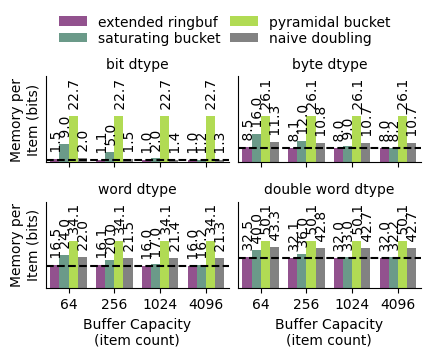

teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=+font.family=serif+hue=algorithm+kind=bar+mark=True+viz=catplot+x=num-sites+y=bits-per-item+ext=.pdf
teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=+font.family=serif+hue=algorithm+kind=bar+mark=True+viz=catplot+x=num-sites+y=bits-per-item+ext=.pgf
teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=+font.family=serif+hue=algorithm+kind=bar+mark=True+viz=catplot+x=num-sites+y=bits-per-item+ext=.png


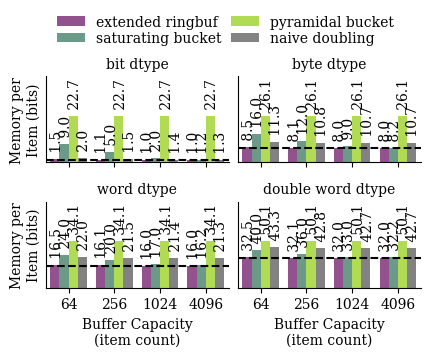

teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=pyramidal-bucket+hue=algorithm+kind=bar+mark=True+viz=catplot+x=num-sites+y=bits-per-item+ext=.pdf
teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=pyramidal-bucket+hue=algorithm+kind=bar+mark=True+viz=catplot+x=num-sites+y=bits-per-item+ext=.pgf
teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=pyramidal-bucket+hue=algorithm+kind=bar+mark=True+viz=catplot+x=num-sites+y=bits-per-item+ext=.png


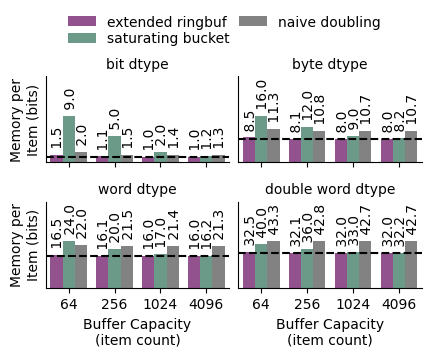

teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=pyramidal-bucket+font.family=serif+hue=algorithm+kind=bar+mark=True+viz=catplot+x=num-sites+y=bits-per-item+ext=.pdf
teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=pyramidal-bucket+font.family=serif+hue=algorithm+kind=bar+mark=True+viz=catplot+x=num-sites+y=bits-per-item+ext=.pgf
teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=pyramidal-bucket+font.family=serif+hue=algorithm+kind=bar+mark=True+viz=catplot+x=num-sites+y=bits-per-item+ext=.png


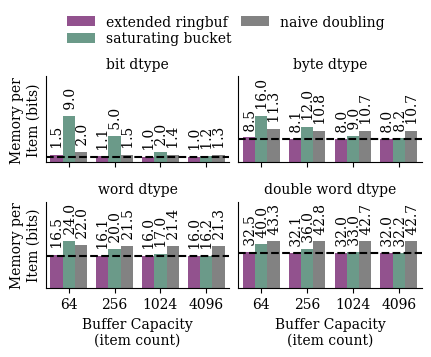

teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=+hue=algorithm+kind=bar+mark=False+viz=catplot+x=num-sites+y=bits-per-item+ext=.pdf
teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=+hue=algorithm+kind=bar+mark=False+viz=catplot+x=num-sites+y=bits-per-item+ext=.pgf
teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=+hue=algorithm+kind=bar+mark=False+viz=catplot+x=num-sites+y=bits-per-item+ext=.png


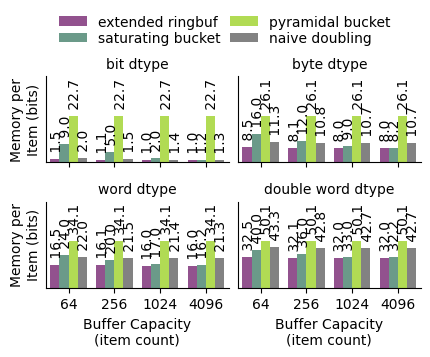

teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=+font.family=serif+hue=algorithm+kind=bar+mark=False+viz=catplot+x=num-sites+y=bits-per-item+ext=.pdf
teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=+font.family=serif+hue=algorithm+kind=bar+mark=False+viz=catplot+x=num-sites+y=bits-per-item+ext=.pgf
teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=+font.family=serif+hue=algorithm+kind=bar+mark=False+viz=catplot+x=num-sites+y=bits-per-item+ext=.png


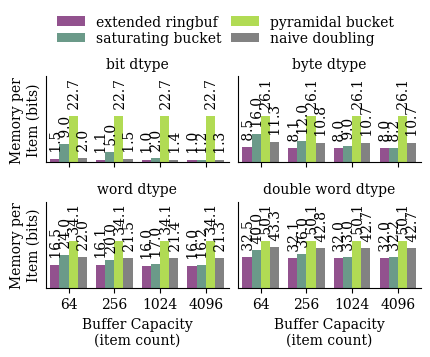

teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=pyramidal-bucket+hue=algorithm+kind=bar+mark=False+viz=catplot+x=num-sites+y=bits-per-item+ext=.pdf
teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=pyramidal-bucket+hue=algorithm+kind=bar+mark=False+viz=catplot+x=num-sites+y=bits-per-item+ext=.pgf
teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=pyramidal-bucket+hue=algorithm+kind=bar+mark=False+viz=catplot+x=num-sites+y=bits-per-item+ext=.png


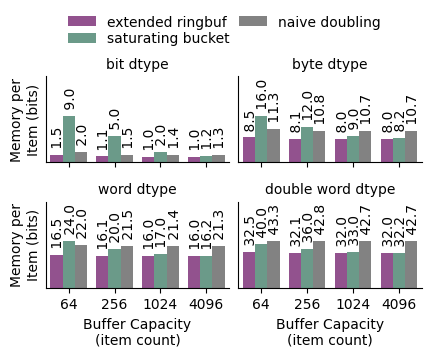

teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=pyramidal-bucket+font.family=serif+hue=algorithm+kind=bar+mark=False+viz=catplot+x=num-sites+y=bits-per-item+ext=.pdf
teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=pyramidal-bucket+font.family=serif+hue=algorithm+kind=bar+mark=False+viz=catplot+x=num-sites+y=bits-per-item+ext=.pgf
teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=pyramidal-bucket+font.family=serif+hue=algorithm+kind=bar+mark=False+viz=catplot+x=num-sites+y=bits-per-item+ext=.png


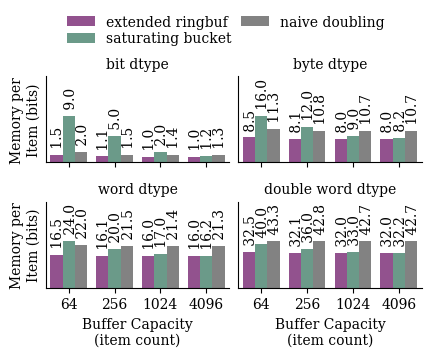

teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=+hue=algorithm+kind=bar+mark=True+viz=catplot+x=num-sites+y=bytes-per-item+ext=.pdf
teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=+hue=algorithm+kind=bar+mark=True+viz=catplot+x=num-sites+y=bytes-per-item+ext=.pgf
teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=+hue=algorithm+kind=bar+mark=True+viz=catplot+x=num-sites+y=bytes-per-item+ext=.png


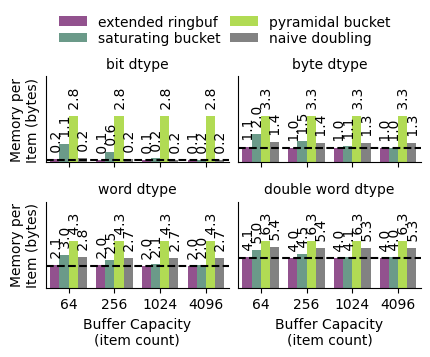

teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=+font.family=serif+hue=algorithm+kind=bar+mark=True+viz=catplot+x=num-sites+y=bytes-per-item+ext=.pdf
teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=+font.family=serif+hue=algorithm+kind=bar+mark=True+viz=catplot+x=num-sites+y=bytes-per-item+ext=.pgf
teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=+font.family=serif+hue=algorithm+kind=bar+mark=True+viz=catplot+x=num-sites+y=bytes-per-item+ext=.png


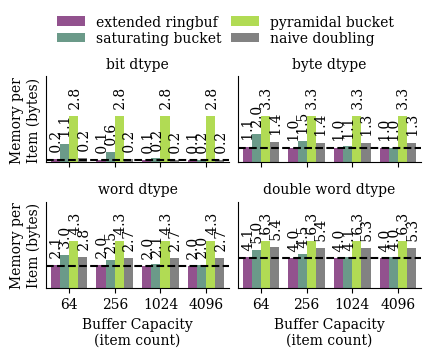

teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=pyramidal-bucket+hue=algorithm+kind=bar+mark=True+viz=catplot+x=num-sites+y=bytes-per-item+ext=.pdf
teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=pyramidal-bucket+hue=algorithm+kind=bar+mark=True+viz=catplot+x=num-sites+y=bytes-per-item+ext=.pgf
teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=pyramidal-bucket+hue=algorithm+kind=bar+mark=True+viz=catplot+x=num-sites+y=bytes-per-item+ext=.png


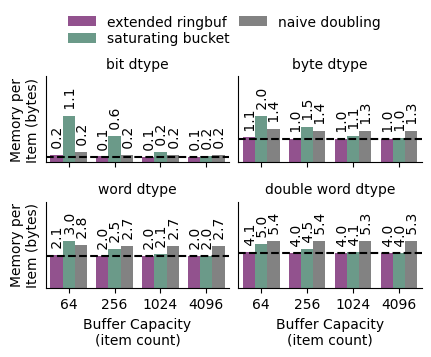

teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=pyramidal-bucket+font.family=serif+hue=algorithm+kind=bar+mark=True+viz=catplot+x=num-sites+y=bytes-per-item+ext=.pdf
teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=pyramidal-bucket+font.family=serif+hue=algorithm+kind=bar+mark=True+viz=catplot+x=num-sites+y=bytes-per-item+ext=.pgf
teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=pyramidal-bucket+font.family=serif+hue=algorithm+kind=bar+mark=True+viz=catplot+x=num-sites+y=bytes-per-item+ext=.png


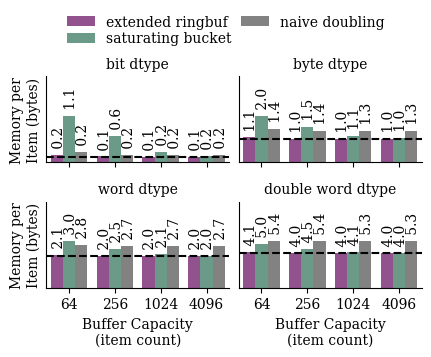

teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=+hue=algorithm+kind=bar+mark=False+viz=catplot+x=num-sites+y=bytes-per-item+ext=.pdf
teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=+hue=algorithm+kind=bar+mark=False+viz=catplot+x=num-sites+y=bytes-per-item+ext=.pgf
teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=+hue=algorithm+kind=bar+mark=False+viz=catplot+x=num-sites+y=bytes-per-item+ext=.png


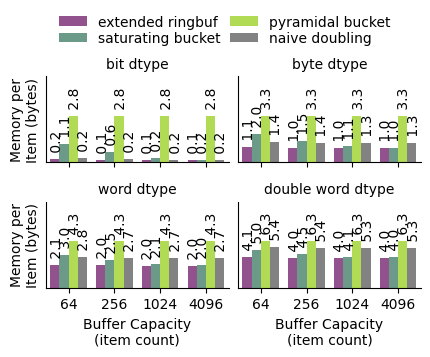

teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=+font.family=serif+hue=algorithm+kind=bar+mark=False+viz=catplot+x=num-sites+y=bytes-per-item+ext=.pdf
teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=+font.family=serif+hue=algorithm+kind=bar+mark=False+viz=catplot+x=num-sites+y=bytes-per-item+ext=.pgf
teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=+font.family=serif+hue=algorithm+kind=bar+mark=False+viz=catplot+x=num-sites+y=bytes-per-item+ext=.png


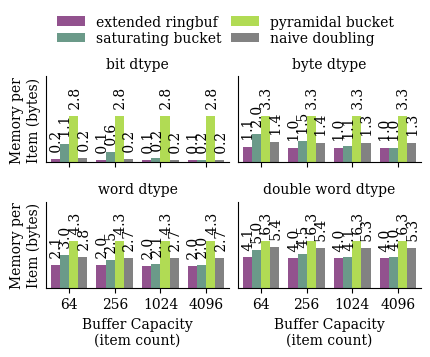

teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=pyramidal-bucket+hue=algorithm+kind=bar+mark=False+viz=catplot+x=num-sites+y=bytes-per-item+ext=.pdf
teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=pyramidal-bucket+hue=algorithm+kind=bar+mark=False+viz=catplot+x=num-sites+y=bytes-per-item+ext=.pgf
teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=pyramidal-bucket+hue=algorithm+kind=bar+mark=False+viz=catplot+x=num-sites+y=bytes-per-item+ext=.png


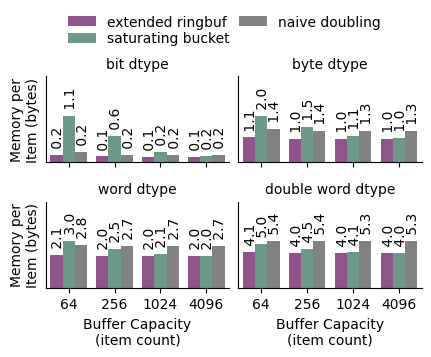

teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=pyramidal-bucket+font.family=serif+hue=algorithm+kind=bar+mark=False+viz=catplot+x=num-sites+y=bytes-per-item+ext=.pdf
teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=pyramidal-bucket+font.family=serif+hue=algorithm+kind=bar+mark=False+viz=catplot+x=num-sites+y=bytes-per-item+ext=.pgf
teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=pyramidal-bucket+font.family=serif+hue=algorithm+kind=bar+mark=False+viz=catplot+x=num-sites+y=bytes-per-item+ext=.png


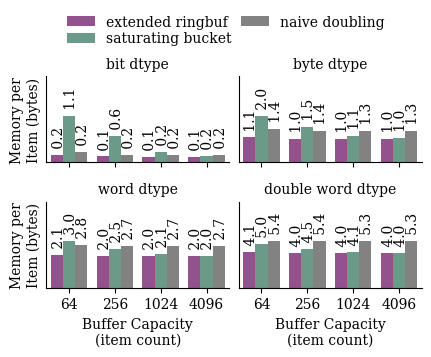

In [10]:
for unit, mark, excl, rc in it.product(
    ["bits", "bytes"],
    [True, False],
    [[], ["pyramidal bucket"]],
    [{}, {"font.family": "serif"}],
):
    excl_hue_order = [hue for hue in hue_order if hue not in excl]
    with mpl.rc_context(rc=rc):
        with tp.teed(
            sns.catplot,
            data=df.filter(
                pl.col("num_items") == 1_000_000,
            ),
            x="num_sites",
            y=f"{unit} per item",
            hue="algorithm",
            hue_order=excl_hue_order,
            col="data type",
            col_wrap=2,
            col_order=["bit", "byte", "word", "double word"],
            kind="bar",
            errorbar=None,
            margin_titles=True,
            aspect=1.4,
            height=1.6,
            palette=[*map(palette_assignments.get, excl_hue_order)],
            sharex=True,
            sharey=False,
            teeplot_outattrs={
                "excl": slugify("-".join(excl)),
                "mark": mark,
                **rc,
            },
            teeplot_subdir=teeplot_subdir,
        ) as g:
            g.set(ylim=(0, None), yticks=[])
            g.set_titles(col_template="{col_name} dtype")
            g.set_xlabels("Buffer Capacity\n(item count)")
            g.set_ylabels(f"Memory per\nItem ({unit})")
            sns.move_legend(
                g,
                "lower center",
                bbox_to_anchor=(0.37, 0.95),
                columnspacing=0.7,
                labelspacing=0.2,
                ncol=2,
                frameon=False,
                title=None,
            )
            for idx, ax in enumerate(g.axes.flat):
                ax.set_ylim(0, ax.get_ylim()[1] * 1.75)
                for container in ax.containers:
                    anns = ax.bar_label(
                        container,
                        fmt=" %.1f",
                        label_type="edge",
                        rotation=90,
                        padding=2,
                    )
                    for ann in anns:
                        ann_x, ann_y = ann.get_position()
                        ann.set_position((ann_x + 1.35, ann_y))

                if mark:
                    unit_scale = {"bits": 1, "bytes": 1 / 8}[unit]
                    bits = [1, 8, 16, 32][idx]
                    ax.axhline(
                        bits * unit_scale,
                        color="k",
                        linestyle="--",
                    )
            g.tight_layout()
            g.figure.subplots_adjust(wspace=0.05)


## Memory Efficiency


teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=+hue=algorithm+kind=bar+mark=True+viz=catplot+x=num-sites+y=memory-efficiency+ext=.pdf
teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=+hue=algorithm+kind=bar+mark=True+viz=catplot+x=num-sites+y=memory-efficiency+ext=.pgf
teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=+hue=algorithm+kind=bar+mark=True+viz=catplot+x=num-sites+y=memory-efficiency+ext=.png


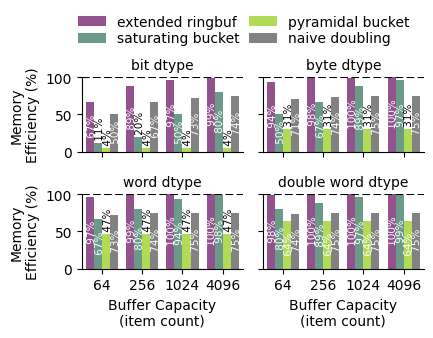

teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=+font.family=serif+hue=algorithm+kind=bar+mark=True+viz=catplot+x=num-sites+y=memory-efficiency+ext=.pdf
teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=+font.family=serif+hue=algorithm+kind=bar+mark=True+viz=catplot+x=num-sites+y=memory-efficiency+ext=.pgf
teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=+font.family=serif+hue=algorithm+kind=bar+mark=True+viz=catplot+x=num-sites+y=memory-efficiency+ext=.png


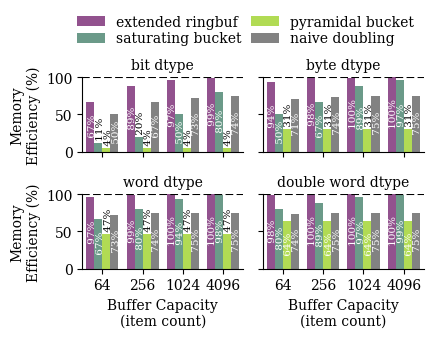

teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=pyramidal-bucket+hue=algorithm+kind=bar+mark=True+viz=catplot+x=num-sites+y=memory-efficiency+ext=.pdf
teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=pyramidal-bucket+hue=algorithm+kind=bar+mark=True+viz=catplot+x=num-sites+y=memory-efficiency+ext=.pgf
teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=pyramidal-bucket+hue=algorithm+kind=bar+mark=True+viz=catplot+x=num-sites+y=memory-efficiency+ext=.png


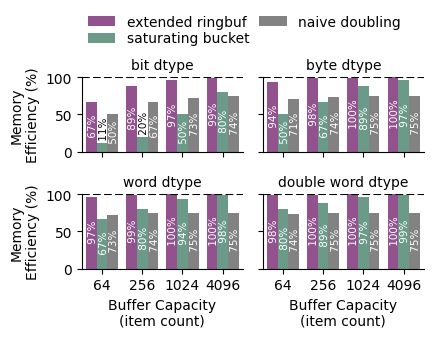

teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=pyramidal-bucket+font.family=serif+hue=algorithm+kind=bar+mark=True+viz=catplot+x=num-sites+y=memory-efficiency+ext=.pdf
teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=pyramidal-bucket+font.family=serif+hue=algorithm+kind=bar+mark=True+viz=catplot+x=num-sites+y=memory-efficiency+ext=.pgf
teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=pyramidal-bucket+font.family=serif+hue=algorithm+kind=bar+mark=True+viz=catplot+x=num-sites+y=memory-efficiency+ext=.png


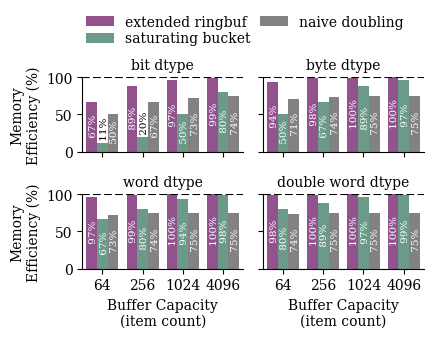

teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=+hue=algorithm+kind=bar+mark=False+viz=catplot+x=num-sites+y=memory-efficiency+ext=.pdf
teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=+hue=algorithm+kind=bar+mark=False+viz=catplot+x=num-sites+y=memory-efficiency+ext=.pgf
teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=+hue=algorithm+kind=bar+mark=False+viz=catplot+x=num-sites+y=memory-efficiency+ext=.png


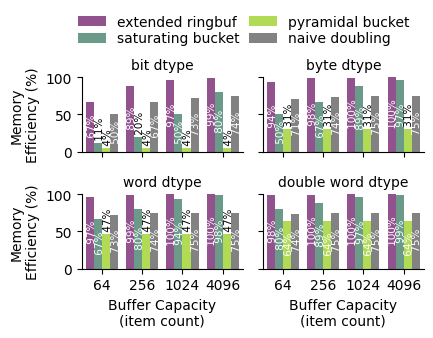

teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=+font.family=serif+hue=algorithm+kind=bar+mark=False+viz=catplot+x=num-sites+y=memory-efficiency+ext=.pdf
teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=+font.family=serif+hue=algorithm+kind=bar+mark=False+viz=catplot+x=num-sites+y=memory-efficiency+ext=.pgf
teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=+font.family=serif+hue=algorithm+kind=bar+mark=False+viz=catplot+x=num-sites+y=memory-efficiency+ext=.png


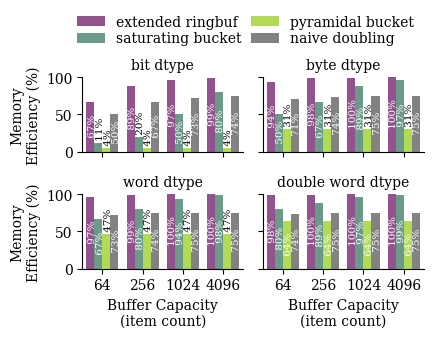

teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=pyramidal-bucket+hue=algorithm+kind=bar+mark=False+viz=catplot+x=num-sites+y=memory-efficiency+ext=.pdf
teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=pyramidal-bucket+hue=algorithm+kind=bar+mark=False+viz=catplot+x=num-sites+y=memory-efficiency+ext=.pgf
teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=pyramidal-bucket+hue=algorithm+kind=bar+mark=False+viz=catplot+x=num-sites+y=memory-efficiency+ext=.png


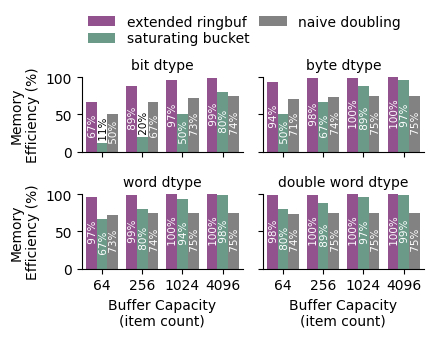

teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=pyramidal-bucket+font.family=serif+hue=algorithm+kind=bar+mark=False+viz=catplot+x=num-sites+y=memory-efficiency+ext=.pdf
teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=pyramidal-bucket+font.family=serif+hue=algorithm+kind=bar+mark=False+viz=catplot+x=num-sites+y=memory-efficiency+ext=.pgf
teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=pyramidal-bucket+font.family=serif+hue=algorithm+kind=bar+mark=False+viz=catplot+x=num-sites+y=memory-efficiency+ext=.png


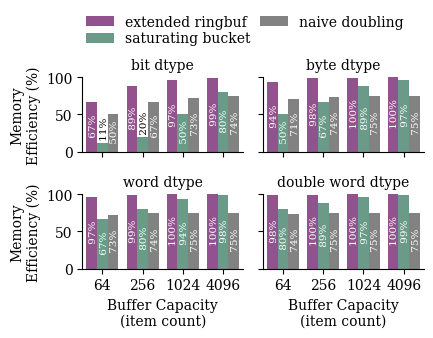

In [11]:
for mark, excl, rc in it.product(
    [True, False],
    [[], ["pyramidal bucket"]],
    [{}, {"font.family": "serif"}],
):
    excl_hue_order = [hue for hue in hue_order if hue not in excl]
    with mpl.rc_context(rc=rc):
        with tp.teed(
            sns.catplot,
            data=df.filter(
                pl.col("num_items") == 1_000_000,
            ),
            x="num_sites",
            y="Memory Efficiency (%)",
            hue="algorithm",
            hue_order=excl_hue_order,
            col="data type",
            col_wrap=2,
            col_order=["bit", "byte", "word", "double word"],
            kind="bar",
            errorbar=None,
            margin_titles=True,
            aspect=1.5,
            height=1.5,
            gap=0.0,
            palette=[*map(palette_assignments.get, excl_hue_order)],
            sharex=True,
            sharey=True,
            teeplot_outattrs={
                "excl": slugify("-".join(excl)),
                "mark": mark,
                **rc,
            },
            teeplot_subdir=teeplot_subdir,
        ) as g:
            g.set(ylim=(0, None))
            g.set_titles(col_template="{col_name} dtype")
            g.set_xlabels("Buffer Capacity\n(item count)")
            g.set_ylabels("Memory\nEfficiency (%)")
            sns.move_legend(
                g,
                "lower center",
                bbox_to_anchor=(0.4, 0.95),
                columnspacing=0.7,
                labelspacing=0.2,
                ncol=2,
                frameon=False,
                title=None,
            )
            for idx, ax in enumerate(g.axes.flat):
                ax.set_ylim(0, 100)
                for container in ax.containers:
                    for bar in container:
                        shrink = bool(bar.get_height() < 50)
                        ann = ax.bar_label(
                            mpl_container.BarContainer(
                                [bar],
                                datavalues=[bar.get_height()],
                                orientation="vertical",
                            ),
                            color=["white", "black"][shrink],
                            fmt=" %.0f%%",
                            fontsize=7.5,
                            label_type=["center", "edge"][shrink],
                            rotation=90,
                        )[0]
                        ann_x, ann_y = ann.get_position()
                        ann.set_position((ann_x + 1.25, ann_y))

                if mark:
                    ax.axhline(
                        100,
                        color="k",
                        linestyle="--",
                    )
            g.tight_layout()


## Memory Efficiency --- Stacked


teeplots/2025-06-30-cpp-bench-memory-tilted/col=stat+excl=+hue=algorithm+kind=bar+legend=True+row=data-type+viz=catplot+x=num-sites+y=memory-efficiency+ext=.pdf
teeplots/2025-06-30-cpp-bench-memory-tilted/col=stat+excl=+hue=algorithm+kind=bar+legend=True+row=data-type+viz=catplot+x=num-sites+y=memory-efficiency+ext=.pgf
teeplots/2025-06-30-cpp-bench-memory-tilted/col=stat+excl=+hue=algorithm+kind=bar+legend=True+row=data-type+viz=catplot+x=num-sites+y=memory-efficiency+ext=.png


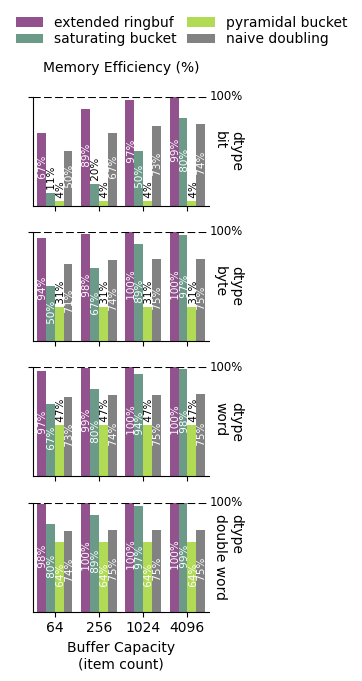

teeplots/2025-06-30-cpp-bench-memory-tilted/col=stat+excl=+font.family=serif+hue=algorithm+kind=bar+legend=True+row=data-type+viz=catplot+x=num-sites+y=memory-efficiency+ext=.pdf
teeplots/2025-06-30-cpp-bench-memory-tilted/col=stat+excl=+font.family=serif+hue=algorithm+kind=bar+legend=True+row=data-type+viz=catplot+x=num-sites+y=memory-efficiency+ext=.pgf
teeplots/2025-06-30-cpp-bench-memory-tilted/col=stat+excl=+font.family=serif+hue=algorithm+kind=bar+legend=True+row=data-type+viz=catplot+x=num-sites+y=memory-efficiency+ext=.png


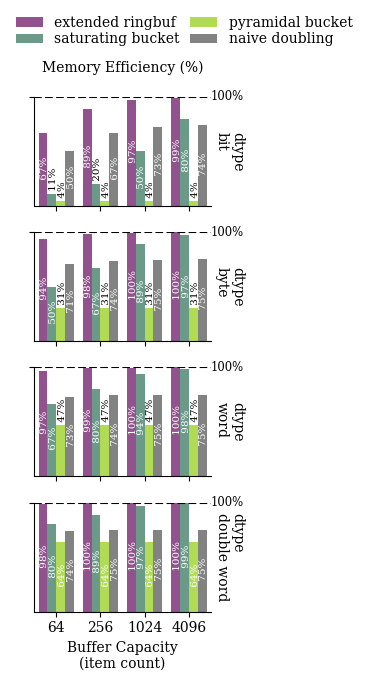

teeplots/2025-06-30-cpp-bench-memory-tilted/col=stat+excl=pyramidal-bucket+hue=algorithm+kind=bar+legend=True+row=data-type+viz=catplot+x=num-sites+y=memory-efficiency+ext=.pdf
teeplots/2025-06-30-cpp-bench-memory-tilted/col=stat+excl=pyramidal-bucket+hue=algorithm+kind=bar+legend=True+row=data-type+viz=catplot+x=num-sites+y=memory-efficiency+ext=.pgf
teeplots/2025-06-30-cpp-bench-memory-tilted/col=stat+excl=pyramidal-bucket+hue=algorithm+kind=bar+legend=True+row=data-type+viz=catplot+x=num-sites+y=memory-efficiency+ext=.png


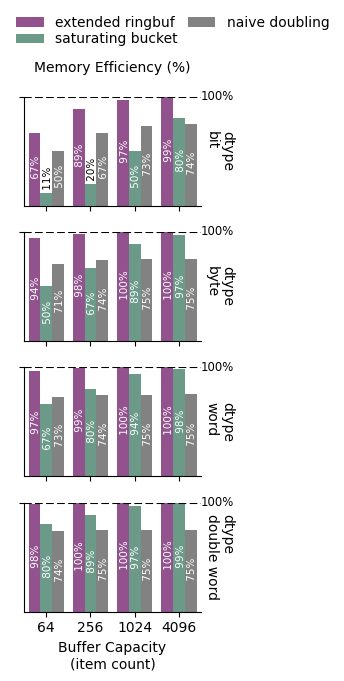

teeplots/2025-06-30-cpp-bench-memory-tilted/col=stat+excl=pyramidal-bucket+font.family=serif+hue=algorithm+kind=bar+legend=True+row=data-type+viz=catplot+x=num-sites+y=memory-efficiency+ext=.pdf
teeplots/2025-06-30-cpp-bench-memory-tilted/col=stat+excl=pyramidal-bucket+font.family=serif+hue=algorithm+kind=bar+legend=True+row=data-type+viz=catplot+x=num-sites+y=memory-efficiency+ext=.pgf
teeplots/2025-06-30-cpp-bench-memory-tilted/col=stat+excl=pyramidal-bucket+font.family=serif+hue=algorithm+kind=bar+legend=True+row=data-type+viz=catplot+x=num-sites+y=memory-efficiency+ext=.png


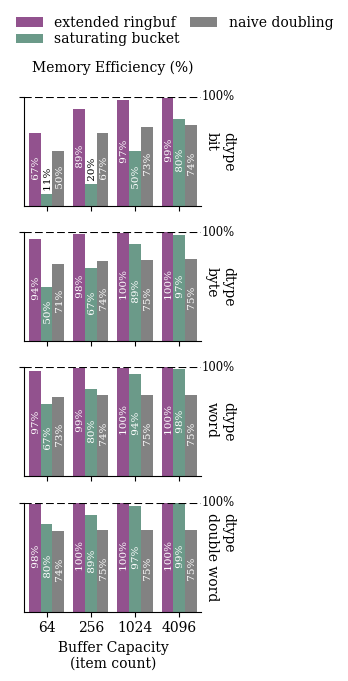

teeplots/2025-06-30-cpp-bench-memory-tilted/col=stat+excl=+hue=algorithm+kind=bar+legend=False+row=data-type+viz=catplot+x=num-sites+y=memory-efficiency+ext=.pdf
teeplots/2025-06-30-cpp-bench-memory-tilted/col=stat+excl=+hue=algorithm+kind=bar+legend=False+row=data-type+viz=catplot+x=num-sites+y=memory-efficiency+ext=.pgf
teeplots/2025-06-30-cpp-bench-memory-tilted/col=stat+excl=+hue=algorithm+kind=bar+legend=False+row=data-type+viz=catplot+x=num-sites+y=memory-efficiency+ext=.png


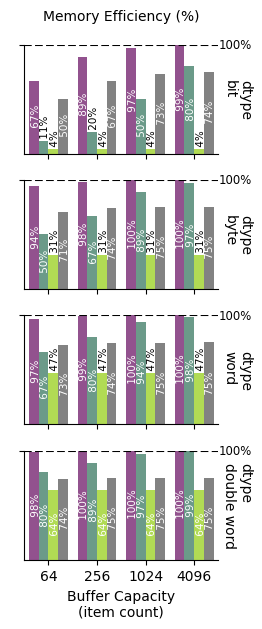

teeplots/2025-06-30-cpp-bench-memory-tilted/col=stat+excl=+font.family=serif+hue=algorithm+kind=bar+legend=False+row=data-type+viz=catplot+x=num-sites+y=memory-efficiency+ext=.pdf
teeplots/2025-06-30-cpp-bench-memory-tilted/col=stat+excl=+font.family=serif+hue=algorithm+kind=bar+legend=False+row=data-type+viz=catplot+x=num-sites+y=memory-efficiency+ext=.pgf
teeplots/2025-06-30-cpp-bench-memory-tilted/col=stat+excl=+font.family=serif+hue=algorithm+kind=bar+legend=False+row=data-type+viz=catplot+x=num-sites+y=memory-efficiency+ext=.png


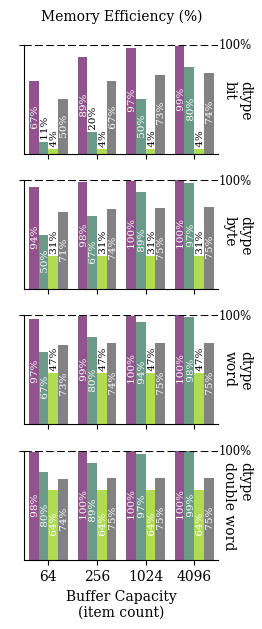

teeplots/2025-06-30-cpp-bench-memory-tilted/col=stat+excl=pyramidal-bucket+hue=algorithm+kind=bar+legend=False+row=data-type+viz=catplot+x=num-sites+y=memory-efficiency+ext=.pdf
teeplots/2025-06-30-cpp-bench-memory-tilted/col=stat+excl=pyramidal-bucket+hue=algorithm+kind=bar+legend=False+row=data-type+viz=catplot+x=num-sites+y=memory-efficiency+ext=.pgf
teeplots/2025-06-30-cpp-bench-memory-tilted/col=stat+excl=pyramidal-bucket+hue=algorithm+kind=bar+legend=False+row=data-type+viz=catplot+x=num-sites+y=memory-efficiency+ext=.png


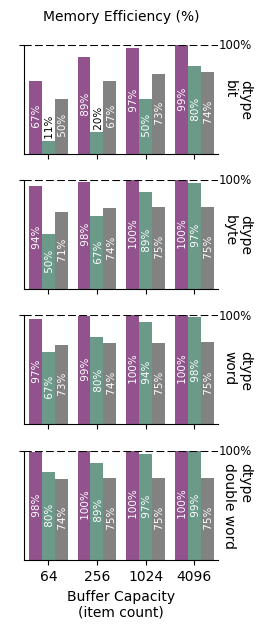

teeplots/2025-06-30-cpp-bench-memory-tilted/col=stat+excl=pyramidal-bucket+font.family=serif+hue=algorithm+kind=bar+legend=False+row=data-type+viz=catplot+x=num-sites+y=memory-efficiency+ext=.pdf
teeplots/2025-06-30-cpp-bench-memory-tilted/col=stat+excl=pyramidal-bucket+font.family=serif+hue=algorithm+kind=bar+legend=False+row=data-type+viz=catplot+x=num-sites+y=memory-efficiency+ext=.pgf
teeplots/2025-06-30-cpp-bench-memory-tilted/col=stat+excl=pyramidal-bucket+font.family=serif+hue=algorithm+kind=bar+legend=False+row=data-type+viz=catplot+x=num-sites+y=memory-efficiency+ext=.png


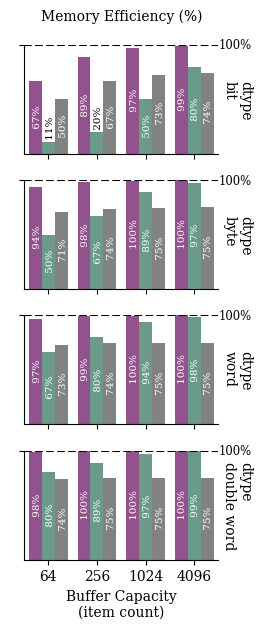

In [12]:
for legend, excl, rc in it.product(
    [True, False],
    [[], ["pyramidal bucket"]],
    [{}, {"font.family": "serif"}],
):
    excl_hue_order = [hue for hue in hue_order if hue not in excl]
    with mpl.rc_context(rc=rc):
        with tp.teed(
            sns.catplot,
            data=df.filter(
                pl.col("num_items") == 1_000_000,
            ).with_columns(
                stat=pl.lit("Memory Efficiency (%)\n"),
            ),
            x="num_sites",
            y="Memory Efficiency (%)",
            hue="algorithm",
            hue_order=excl_hue_order,
            col="stat",
            row="data type",
            row_order=["bit", "byte", "word", "double word"],
            kind="bar",
            errorbar=None,
            legend=legend,
            margin_titles=True,
            aspect=1.7,
            height=1.6,
            gap=0.0,
            palette=[*map(palette_assignments.get, excl_hue_order)],
            sharex=True,
            sharey=True,
            teeplot_outattrs={
                "excl": slugify("-".join(excl)),
                "legend": legend,
                **rc,
            },
            teeplot_subdir=teeplot_subdir,
        ) as g:
            g.set(ylim=(0, None))
            g.set_titles(
                col_template="{col_name}",
                row_template="dtype\n{row_name}"
            )
            g.set_xlabels("Buffer Capacity\n(item count)")
            g.set_ylabels("")
            if legend:
                sns.move_legend(
                    g,
                    "lower center",
                    bbox_to_anchor=(0.4, 0.98),
                    columnspacing=0.7,
                    labelspacing=0.2,
                    ncol=2,
                    frameon=False,
                    title=None,
                )
            for idx, ax in enumerate(g.axes.flat):
                ax.set_ylim(0, 100)
                ax.set_yticks([100])
                ax.set_yticklabels([" "])
                for container in ax.containers:
                    for bar in container:
                        shrink = bool(bar.get_height() < 50)
                        ann = ax.bar_label(
                            mpl_container.BarContainer(
                                [bar],
                                datavalues=[bar.get_height()],
                                orientation="vertical",
                            ),
                            color=["white", "black"][shrink],
                            fmt=" %.0f%%",
                            fontsize=7.5,
                            label_type=["center", "edge"][shrink],
                            rotation=90,
                        )[0]
                        ann_x, ann_y = ann.get_position()
                        ann.set_position((ann_x + 1.25, ann_y))

                ax.axhline(
                    100,
                    color="k",
                    linestyle="--",
                )
                ax.annotate(
                    "100%",
                    xy=(1.0, 1.0),
                    xycoords="axes fraction",
                    ha="left",
                    va="center",
                    size="small",
                    clip_on=False,
                )
            g.tight_layout()


## Memory Footprint


teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=+hue=algorithm+kind=bar+mark=True+row=num-sites+viz=catplot+y=memory-bytes+ext=.pdf
teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=+hue=algorithm+kind=bar+mark=True+row=num-sites+viz=catplot+y=memory-bytes+ext=.pgf
teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=+hue=algorithm+kind=bar+mark=True+row=num-sites+viz=catplot+y=memory-bytes+ext=.png


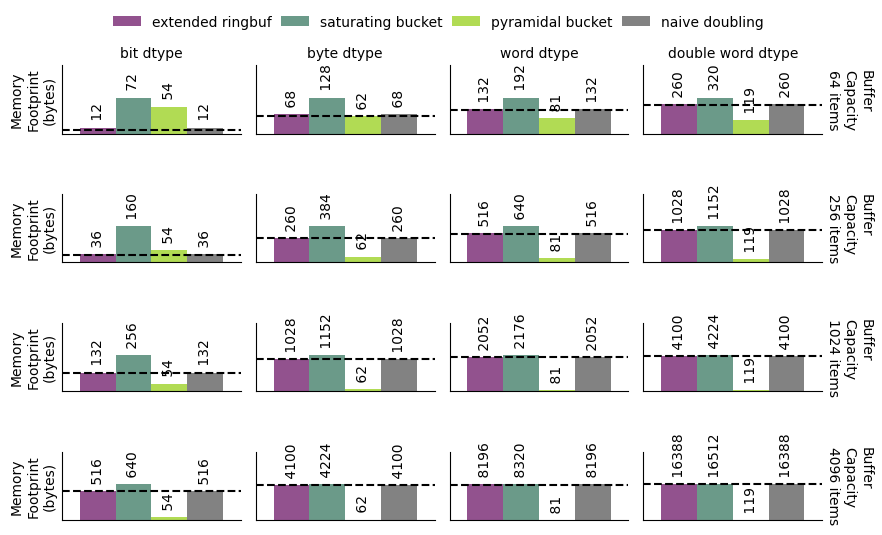

teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=+font.family=serif+hue=algorithm+kind=bar+mark=True+row=num-sites+viz=catplot+y=memory-bytes+ext=.pdf
teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=+font.family=serif+hue=algorithm+kind=bar+mark=True+row=num-sites+viz=catplot+y=memory-bytes+ext=.pgf
teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=+font.family=serif+hue=algorithm+kind=bar+mark=True+row=num-sites+viz=catplot+y=memory-bytes+ext=.png


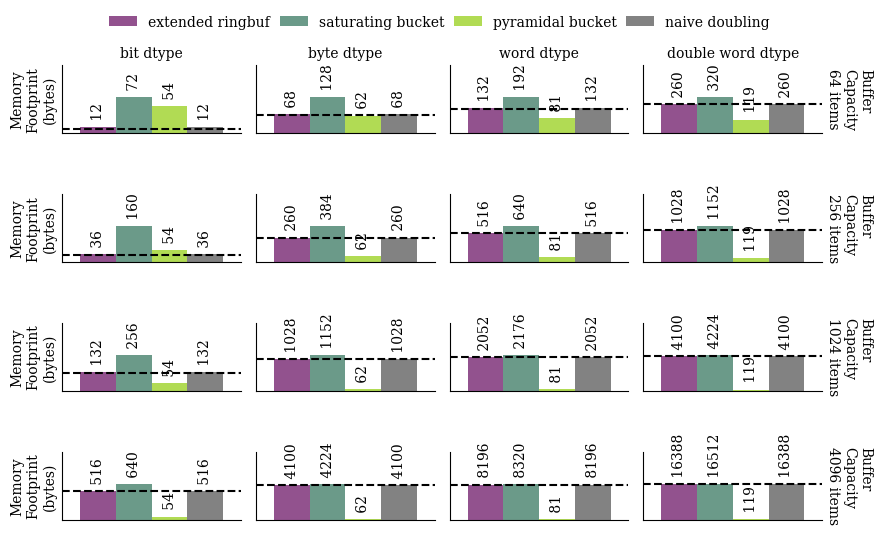

teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=pyramidal-bucket+hue=algorithm+kind=bar+mark=True+row=num-sites+viz=catplot+y=memory-bytes+ext=.pdf
teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=pyramidal-bucket+hue=algorithm+kind=bar+mark=True+row=num-sites+viz=catplot+y=memory-bytes+ext=.pgf
teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=pyramidal-bucket+hue=algorithm+kind=bar+mark=True+row=num-sites+viz=catplot+y=memory-bytes+ext=.png


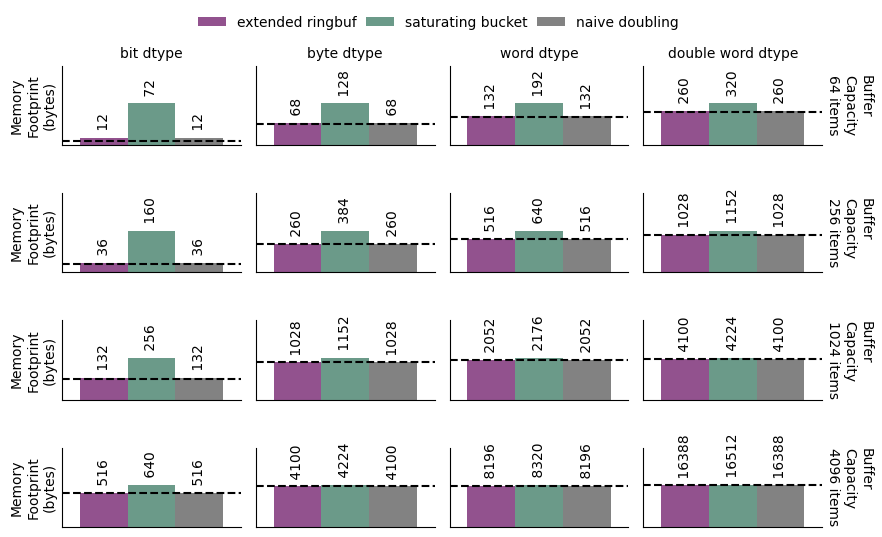

teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=pyramidal-bucket+font.family=serif+hue=algorithm+kind=bar+mark=True+row=num-sites+viz=catplot+y=memory-bytes+ext=.pdf
teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=pyramidal-bucket+font.family=serif+hue=algorithm+kind=bar+mark=True+row=num-sites+viz=catplot+y=memory-bytes+ext=.pgf
teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=pyramidal-bucket+font.family=serif+hue=algorithm+kind=bar+mark=True+row=num-sites+viz=catplot+y=memory-bytes+ext=.png


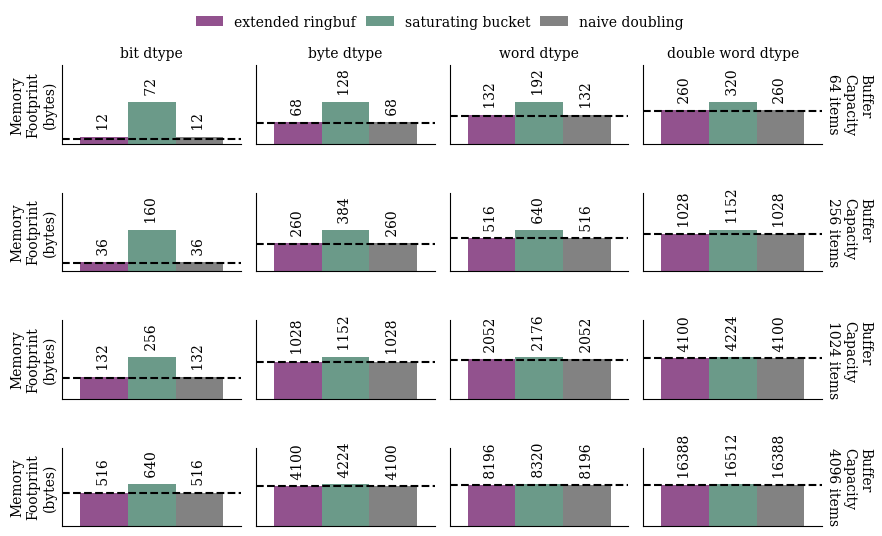

teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=+hue=algorithm+kind=bar+mark=False+row=num-sites+viz=catplot+y=memory-bytes+ext=.pdf
teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=+hue=algorithm+kind=bar+mark=False+row=num-sites+viz=catplot+y=memory-bytes+ext=.pgf
teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=+hue=algorithm+kind=bar+mark=False+row=num-sites+viz=catplot+y=memory-bytes+ext=.png


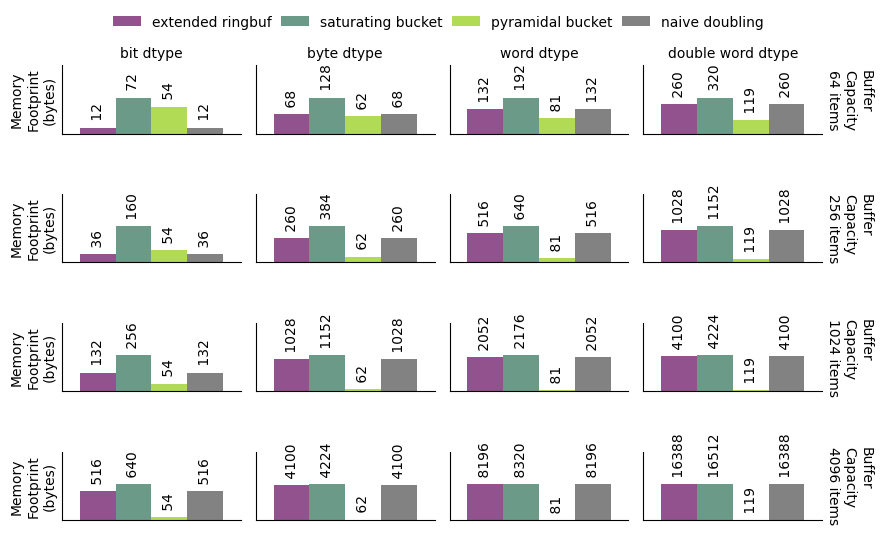

teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=+font.family=serif+hue=algorithm+kind=bar+mark=False+row=num-sites+viz=catplot+y=memory-bytes+ext=.pdf
teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=+font.family=serif+hue=algorithm+kind=bar+mark=False+row=num-sites+viz=catplot+y=memory-bytes+ext=.pgf
teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=+font.family=serif+hue=algorithm+kind=bar+mark=False+row=num-sites+viz=catplot+y=memory-bytes+ext=.png


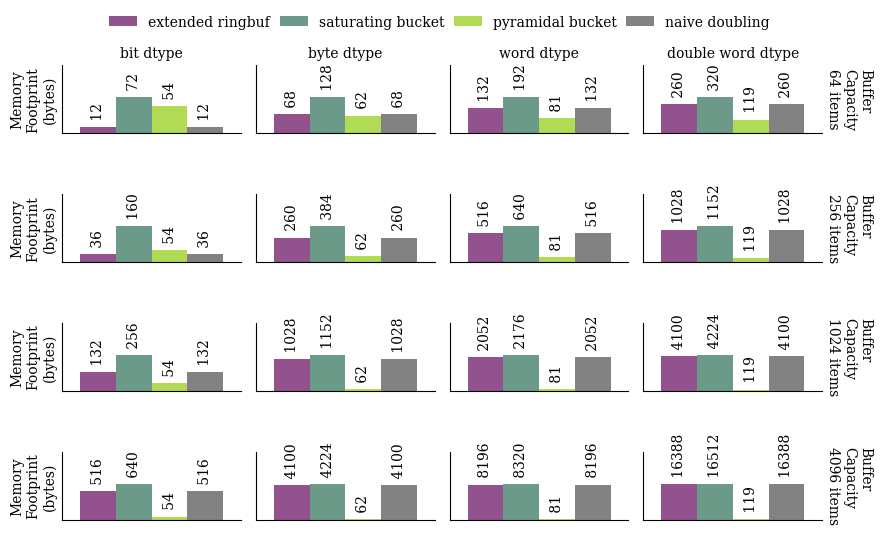

teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=pyramidal-bucket+hue=algorithm+kind=bar+mark=False+row=num-sites+viz=catplot+y=memory-bytes+ext=.pdf
teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=pyramidal-bucket+hue=algorithm+kind=bar+mark=False+row=num-sites+viz=catplot+y=memory-bytes+ext=.pgf
teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=pyramidal-bucket+hue=algorithm+kind=bar+mark=False+row=num-sites+viz=catplot+y=memory-bytes+ext=.png


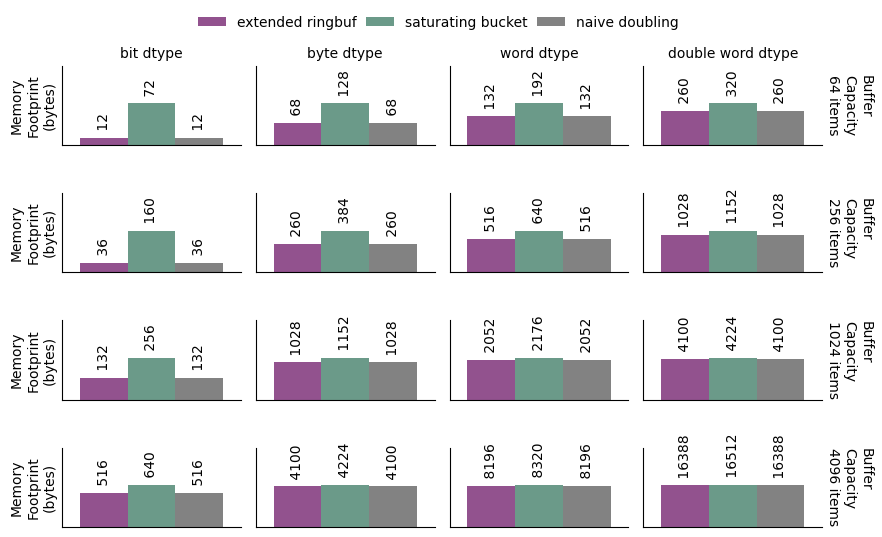

teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=pyramidal-bucket+font.family=serif+hue=algorithm+kind=bar+mark=False+row=num-sites+viz=catplot+y=memory-bytes+ext=.pdf
teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=pyramidal-bucket+font.family=serif+hue=algorithm+kind=bar+mark=False+row=num-sites+viz=catplot+y=memory-bytes+ext=.pgf
teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=pyramidal-bucket+font.family=serif+hue=algorithm+kind=bar+mark=False+row=num-sites+viz=catplot+y=memory-bytes+ext=.png


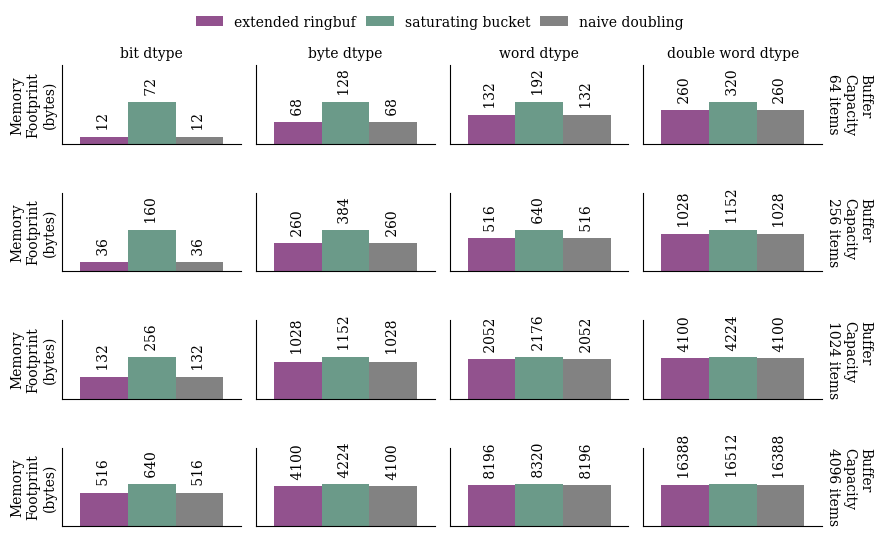

In [13]:
for unit, mark, excl, rc in it.product(
    ["bytes"],
    [True, False],
    [[], ["pyramidal bucket"]],
    [{}, {"font.family": "serif"}],
):
    excl_hue_order = [hue for hue in hue_order if hue not in excl]
    with mpl.rc_context(rc=rc):
        with tp.teed(
            sns.catplot,
            data=df.filter(
                pl.col("num_items") == 1_000_000,
            ),
            y=f"memory_{unit}",
            hue="algorithm",
            hue_order=excl_hue_order,
            col="data type",
            row="num_sites",
            col_order=["bit", "byte", "word", "double word"],
            kind="bar",
            errorbar=None,
            margin_titles=True,
            aspect=1.8,
            height=1.3,
            palette=[*map(palette_assignments.get, excl_hue_order)],
            sharex=True,
            sharey=False,
            teeplot_outattrs={
                "excl": slugify("-".join(excl)),
                "mark": mark,
                **rc,
            },
            teeplot_subdir=teeplot_subdir,
        ) as g:
            g.set(ylim=(0, None), xticks=[], yticks=[])
            g.set_titles(
                col_template="{col_name} dtype",
                row_template="Buffer\nCapacity\n{row_name} items",
            )
            g.set_ylabels(f"Memory\nFootprint\n({unit})")
            sns.move_legend(
                g,
                "lower center",
                bbox_to_anchor=(0.4, 0.98),
                columnspacing=0.7,
                labelspacing=0.2,
                ncol=4,
                frameon=False,
                title=None,
            )
            for idx, ax in enumerate(g.axes.flat):
                ax.set_ylim(0, ax.get_ylim()[1] * 1.8)
                ax.tick_params(axis="y", labelrotation=60)
                for container in ax.containers:
                    ax.bar_label(
                        container,
                        fmt=" %.0f",
                        label_type="edge",
                        rotation=90,
                        padding=2,
                    )
                if mark:
                    unit_scale = {"bits": 1, "bytes": 1 / 8}[unit]
                    bits = [1, 8, 16, 32][idx % 4]
                    num_sites = [64, 256, 1024, 4096][idx // 4]
                    ax.axhline(
                        bits * unit_scale * num_sites,
                        color="k",
                        linestyle="--",
                    )
            g.tight_layout()


## Memory Overhead


teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=+hue=algorithm+kind=bar+mark=True+viz=catplot+x=num-sites+y=overhead-bytes+ext=.pdf
teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=+hue=algorithm+kind=bar+mark=True+viz=catplot+x=num-sites+y=overhead-bytes+ext=.pgf
teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=+hue=algorithm+kind=bar+mark=True+viz=catplot+x=num-sites+y=overhead-bytes+ext=.png


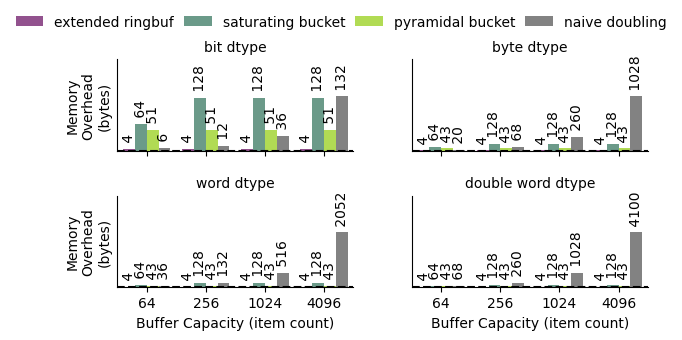

teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=+font.family=serif+hue=algorithm+kind=bar+mark=True+viz=catplot+x=num-sites+y=overhead-bytes+ext=.pdf
teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=+font.family=serif+hue=algorithm+kind=bar+mark=True+viz=catplot+x=num-sites+y=overhead-bytes+ext=.pgf
teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=+font.family=serif+hue=algorithm+kind=bar+mark=True+viz=catplot+x=num-sites+y=overhead-bytes+ext=.png


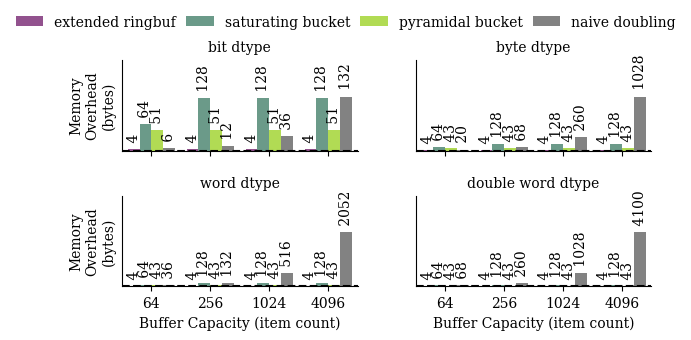

teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=pyramidal-bucket+hue=algorithm+kind=bar+mark=True+viz=catplot+x=num-sites+y=overhead-bytes+ext=.pdf
teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=pyramidal-bucket+hue=algorithm+kind=bar+mark=True+viz=catplot+x=num-sites+y=overhead-bytes+ext=.pgf
teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=pyramidal-bucket+hue=algorithm+kind=bar+mark=True+viz=catplot+x=num-sites+y=overhead-bytes+ext=.png


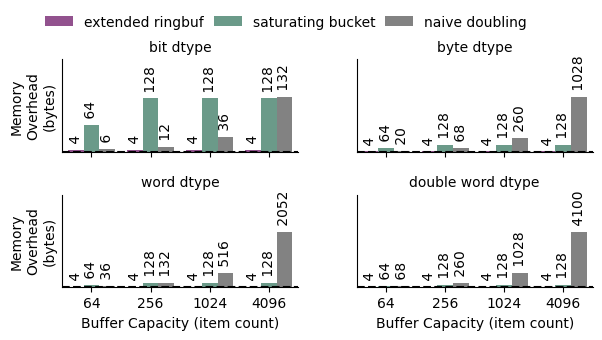

teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=pyramidal-bucket+font.family=serif+hue=algorithm+kind=bar+mark=True+viz=catplot+x=num-sites+y=overhead-bytes+ext=.pdf
teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=pyramidal-bucket+font.family=serif+hue=algorithm+kind=bar+mark=True+viz=catplot+x=num-sites+y=overhead-bytes+ext=.pgf
teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=pyramidal-bucket+font.family=serif+hue=algorithm+kind=bar+mark=True+viz=catplot+x=num-sites+y=overhead-bytes+ext=.png


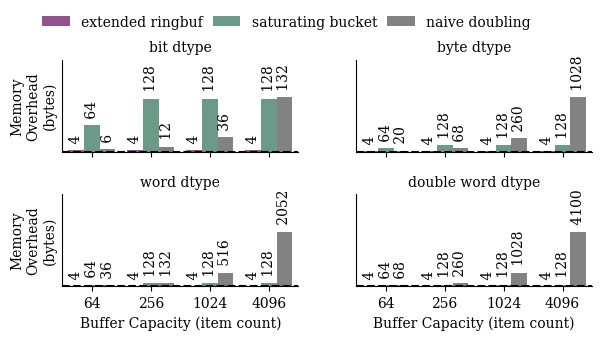

teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=+hue=algorithm+kind=bar+mark=False+viz=catplot+x=num-sites+y=overhead-bytes+ext=.pdf
teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=+hue=algorithm+kind=bar+mark=False+viz=catplot+x=num-sites+y=overhead-bytes+ext=.pgf
teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=+hue=algorithm+kind=bar+mark=False+viz=catplot+x=num-sites+y=overhead-bytes+ext=.png


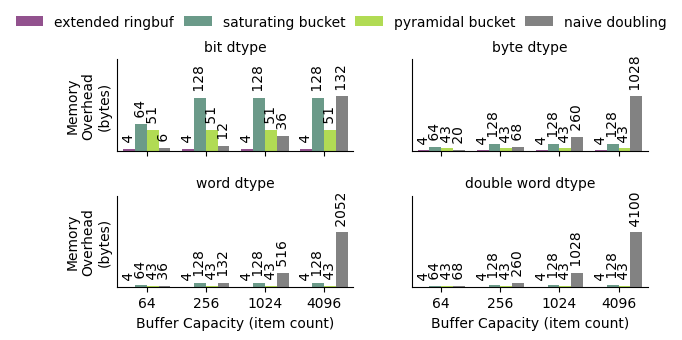

teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=+font.family=serif+hue=algorithm+kind=bar+mark=False+viz=catplot+x=num-sites+y=overhead-bytes+ext=.pdf
teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=+font.family=serif+hue=algorithm+kind=bar+mark=False+viz=catplot+x=num-sites+y=overhead-bytes+ext=.pgf
teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=+font.family=serif+hue=algorithm+kind=bar+mark=False+viz=catplot+x=num-sites+y=overhead-bytes+ext=.png


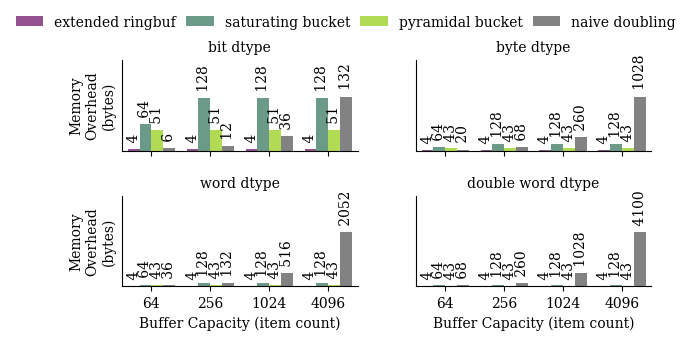

teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=pyramidal-bucket+hue=algorithm+kind=bar+mark=False+viz=catplot+x=num-sites+y=overhead-bytes+ext=.pdf
teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=pyramidal-bucket+hue=algorithm+kind=bar+mark=False+viz=catplot+x=num-sites+y=overhead-bytes+ext=.pgf
teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=pyramidal-bucket+hue=algorithm+kind=bar+mark=False+viz=catplot+x=num-sites+y=overhead-bytes+ext=.png


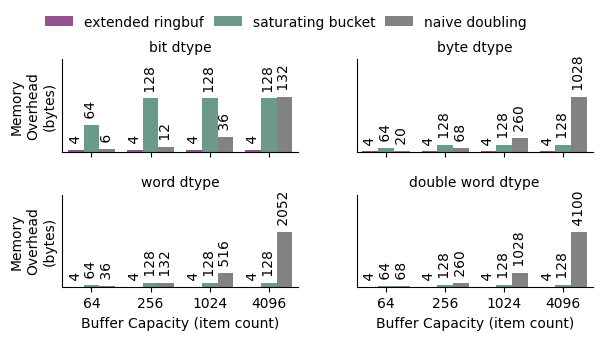

teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=pyramidal-bucket+font.family=serif+hue=algorithm+kind=bar+mark=False+viz=catplot+x=num-sites+y=overhead-bytes+ext=.pdf
teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=pyramidal-bucket+font.family=serif+hue=algorithm+kind=bar+mark=False+viz=catplot+x=num-sites+y=overhead-bytes+ext=.pgf
teeplots/2025-06-30-cpp-bench-memory-tilted/col=data-type+excl=pyramidal-bucket+font.family=serif+hue=algorithm+kind=bar+mark=False+viz=catplot+x=num-sites+y=overhead-bytes+ext=.png


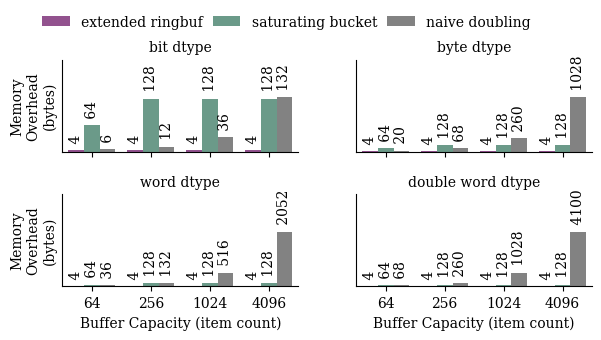

In [14]:
for unit, mark, excl, rc in it.product(
    ["bytes"],
    [True, False],
    [[], ["pyramidal bucket"]],
    [{}, {"font.family": "serif"}],
):
    excl_hue_order = [hue for hue in hue_order if hue not in excl]
    with mpl.rc_context(rc=rc):
        with tp.teed(
            sns.catplot,
            data=df.filter(
                pl.col("num_items") == 1_000_000,
            ),
            x="num_sites",
            y=f"overhead_{unit}",
            hue="algorithm",
            hue_order=excl_hue_order,
            col="data type",
            col_wrap=2,
            col_order=["bit", "byte", "word", "double word"],
            kind="bar",
            errorbar=None,
            margin_titles=True,
            aspect=2,
            height=1.6,
            palette=[*map(palette_assignments.get, excl_hue_order)],
            sharex=True,
            sharey=False,
            teeplot_outattrs={
                "excl": slugify("-".join(excl)),
                "mark": mark,
                **rc,
            },
            teeplot_subdir=teeplot_subdir,
        ) as g:
            g.set(ylim=(0, None), yticks=[])
            g.set_titles(col_template="{col_name} dtype")
            g.set_xlabels("Buffer Capacity (item count)")
            g.set_ylabels(f"Memory\nOverhead\n({unit})")
            sns.move_legend(
                g,
                "lower center",
                bbox_to_anchor=(0.4, 0.95),
                columnspacing=0.7,
                labelspacing=0.2,
                ncol=4,
                frameon=False,
                title=None,
            )
            for idx, ax in enumerate(g.axes.flat):
                ax.set_ylim(0, ax.get_ylim()[1] * 1.6)
                for container in ax.containers:
                    ax.bar_label(
                        container,
                        fmt=" %.0f",
                        label_type="edge",
                        rotation=90,
                        padding=2,
                    )
                if mark:
                    unit_scale = {"bits": 1, "bytes": 1 / 8}[unit]
                    bits = [1, 8, 16, 32][idx]
                    ax.axhline(
                        bits * unit_scale,
                        color="k",
                        linestyle="--",
                    )
